In [38]:
import numpy as np

class Environment:
    def __init__(self, initial_state, dt=0.01, noise_std=0.1):
        """
        Initializes the environment with a specified initial state, time step, and noise standard deviation.
        Args:
        initial_state : list or array-like - Initial state vector [e1, e1_dot, e2, e2_dot]
        dt : float - Time step for the simulation
        noise_std : float - Standard deviation for the Gaussian noise applied to the state space
        """
        # Updated system dynamics matrices A, B1, and B2 based on calculations for vx = 20 m/s
        self.A = np.array([[0, 1, 0, 0],
                           [0, -3.608, 144.321, -0.230],
                           [0, 0, 0, 1],
                           [0, -0.170, 6.804, -4.397]], dtype=np.float32)
        
        self.B1 = np.array([[0],
                            [2.848],
                            [0],
                            [3.516]], dtype=np.float32)
        
        self.B2 = self.B1.copy()  # B1 and B2 are the same based on the model

        # Adding a matrix for noise as an additional control input
        self.B_noise = self.B1.copy()  # You can adjust this matrix based on how noise should affect the system
        
        self.initial_state = np.array(initial_state, dtype=np.float32).reshape(-1, 1)
        self.current_state = self.initial_state.copy()
        self.dt = dt
        self.noise_std = noise_std  # Noise standard deviation for state space

    def reset(self):
        """
        Resets the environment to the initial state.
        """
        self.current_state = self.initial_state.copy()
        return self.current_state

    def next_state(self, u1, u2):
        """
        Computes and updates the environment's current state using given control inputs.
        Args:
        u1 : np.ndarray - Control input vector from agent 1 (human driver)
        u2 : np.ndarray - Control input vector from agent 2 (machine)
        Returns:
        x_next : np.ndarray - Next state vector (column)
        """
        x_current = self.current_state.copy()
        self.current_state = self.predict_next_state(x_current, u1, u2)
        return self.current_state

    def predict_next_state(self, state, u1, u2):
        """
        Predicts the next state given the current state and control inputs, with added Gaussian noise as an additional control input.
        Args:
        state : np.ndarray - Current state from which to predict the next state
        u1 : np.ndarray - Control input vector from agent 1 (human driver)
        u2 : np.ndarray - Control input vector from agent 2 (machine)
        Returns:
        x_next : np.ndarray - Predicted next state vector (column)
        """
        # Ensure control inputs are column vectors
        u1 = np.array(u1).reshape(-1, 1)
        u2 = np.array(u2).reshape(-1, 1)

        # Generate Gaussian noise as an additional control input
        noise = 0*np.random.normal(0, self.noise_std, size=(self.B_noise.shape[1], 1))

        # Compute the rate of change of the state
        x_dot = self.A @ state + self.B1 @ u1 + self.B2 @ u2 + self.B_noise @ noise

        # Integrate to find the next state
        x_next = state + self.dt * x_dot

        # Return the next state as a column vector with noise acting as a control signal
        return x_next

# Example usage:
env = Environment([0.0, 0.0, 0.0, 0.0], noise_std=0.01)  # Initial state with four elements and noise
state = env.reset()
print("Initial state (column vector):\n", state)

next_state = env.next_state(np.array([1.0]), np.array([0.8]))  # Control inputs u1 and u2 as 1D vectors
print("Next state (column vector) with noise:\n", next_state)


Initial state (column vector):
 [[0.]
 [0.]
 [0.]
 [0.]]
Next state (column vector) with noise:
 [[0.      ]
 [0.051264]
 [0.      ]
 [0.063288]]


In [39]:
import numpy as np
from scipy.linalg import solve_continuous_are, solve_continuous_lyapunov

class Agent:
    def __init__(self, A, B, Q, other_agent_B, Q_other ,other_agent_K_init, dt=0.01, learning_rate=0.15, history_size=35):
        """
        Initializes the agent with system matrices, cost matrices, and learning rate for simple gradient descent.
        """
        self.A = A
        self.B = B
        self.Q = Q
        self.R = np.eye(1)  # Identity matrix for R
        self.other_agent_B = other_agent_B
        self.other_agent_K = other_agent_K_init
        self.u_other = 0

        self.dt = dt
        self.P = np.eye(A.shape[0])  # Initialize the Riccati matrix P
        self.K = None
        self.history_size = history_size
        self.state_history = []
        self.K_history = []
        self.u_other_history = []
        
        self.Q0_other = Q_other

        # Initialize theta_other as a vector (one for each diagonal element of Q)
        self.theta_other = np.array([[np.random.uniform(1.001051, 1.0010511)]])  # Initial guess for theta_other as a vector
        self.P_other = 0.1*np.eye(A.shape[0])  # Initial Riccati matrix for the other agent
        self.learning_rate = learning_rate

    def solve_riccati(self):
        """
        Solves the Riccati equation for the agent's control gain K based on the current estimate of the other agent's gain.
        """
        A_eff = self.A - self.other_agent_B @ self.other_agent_K  # Adjusted A matrix considering other agent's gain

        try:
            P = solve_continuous_are(A_eff, self.B, self.Q, self.R)  # Simplified since R = I
            self.P = P
            self.K = self.B.T @ P  # No need for inv(R), because R = I
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation")
            self.P = np.eye(self.A.shape[0]) * 0.01
            self.K = np.zeros((self.B.shape[1], self.A.shape[0]))

    def estimate_P_other(self, current_K):
        """
        Solves the Riccati equation for the other agent to estimate P_other based on theta_other.
        The Riccati equation for the other agent uses the current K of this agent.
        """
        # Create a diagonal Q_other matrix based on the current theta_other vector
        Q_other = self.theta_other*self.Q0_other

        A_eff_other = self.A - self.B @ current_K  # The other agent assumes they know our current K
        try:
            P_other = solve_continuous_are(A_eff_other, self.other_agent_B, Q_other, self.R)  # R = I
            self.P_other = P_other
            self.other_agent_K = self.other_agent_B.T @ P_other  # No inv(R), since R = I
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for other agent")
            self.P_other = np.eye(self.A.shape[0]) * 0.01
            self.other_agent_K = np.zeros((self.other_agent_B.shape[1], self.A.shape[0]))

    def compute_dP_other_dtheta(self, current_K):
        """
        Computes dP_other/dtheta_i by solving the Lyapunov equation derived from the Riccati equation for the i-th theta.
        """
        # Define A_eff_other = A - BK_current
        A_eff_other = self.A - self.B @ current_K


        # Define A_lya based on A_eff_other and P_other
        A_lya = A_eff_other - self.other_agent_B @ self.other_agent_B.T @ self.P_other

        # Solve the Lyapunov equation A_lya^T dP_other/dtheta + dP_other_dtheta A_lya + C_i = 0
        dP_other_dtheta_i = solve_continuous_lyapunov(A_lya.T, self.Q0_other)  # C_i replaces the identity matrix
        return dP_other_dtheta_i

    def get_control_input(self, state):
        """
        Computes the control input given the current state.
        Uses the gain matrix K derived from the Riccati equation solution.
        """
        if self.K is None:
            raise ValueError("K matrix has not been computed. Call solve_riccati() first.")
        
        # Control signal: u = -K * state
        noise = 0.0 * np.random.rand()
        self.u_other = -self.other_agent_K @ state
        control_signal = -self.K @ state + noise
        return control_signal

    def update_state_history(self, state, u_other):
        """
        Updates the state history with the latest state and the control input of the other agent.
        Also keeps track of the agent's gain K.
        """
        if len(self.state_history) > self.history_size:
            self.state_history.pop(0)
            self.u_other_history.pop(0)
            self.K_history.pop(0)

        self.state_history.append(state)
        self.u_other_history.append(u_other)
        self.K_history.append(self.K)
        
    def reset_history(self):
        self.state_history = []
        self.K_history = []
        self.u_other_history = []

    def simulate_trajectory_and_compute_error(self):
        """
        Simulates a trajectory using the current estimated theta_other and computes the state errors with derivatives.
        """
        gradients = np.zeros_like(self.theta_other)  # Initialize gradients for each theta element
        errors = []

        # Initial observed state from the history for trajectory simulation
        estimated_state = self.state_history[0].copy()
        
        # Initialize d_error_dtheta as a list of vectors for each theta parameter
        d_error_dtheta = 0*self.state_history[0]

        for i in range(1, len(self.state_history)):
            # Estimate P_other at each step based on the current K in history
            current_K = self.K_history[i - 1]
            self.estimate_P_other(current_K)
            u_other_predict = -self.other_agent_B.T @ self.P_other @ self.state_history[i-1]

            # State derivative and next estimated state based on predicted u_other
            state_dot = self.A @ estimated_state + self.B @ (-current_K @ self.state_history[i-1]) + self.other_agent_B @ u_other_predict
            estimated_state = estimated_state + self.dt * state_dot

            # Calculate the error with the observed state
            error = self.state_history[i] - estimated_state
            errors.append(error)

            # Update d_error_dtheta for each theta parameter
            #for j in range(len(self.theta_other)):
            dP_other_dtheta_j = self.compute_dP_other_dtheta(current_K)
            d_u_other_predict_dtheta_j = -self.other_agent_B.T @ dP_other_dtheta_j @ self.state_history[i-1] #-self.other_agent_B.T@self.P_other@d_error_dtheta[j]
            d_error_dot_dtheta_j = self.A @ d_error_dtheta + self.other_agent_B @ d_u_other_predict_dtheta_j
            d_error_dtheta = d_error_dtheta + self.dt * d_error_dot_dtheta_j

            # Accumulate gradients for each theta
            gradients = 1*gradients + 1*error.T @ d_error_dtheta

        return gradients

    def recompute_error_history(self):
        """
        Calculates the gradients based on the simulated trajectory error.
        """
        gradients = self.simulate_trajectory_and_compute_error()
        return gradients

    def gradient_descent_update(self):
        """
        Updates theta_other using simple gradient descent based on the computed trajectory errors.
        """
        gradients = self.recompute_error_history()
        #gradient_norm = np.linalg.norm(gradients)
    
        # Apply gradient clipping if norm exceeds the clip value
        #clip_value = 50;
        #if gradient_norm > clip_value:
         #   gradients = gradients * (clip_value / gradient_norm)
        
        # Simple Gradient Descent update
        self.theta_other -= self.learning_rate * gradients/self.history_size
        self.theta_other = np.maximum(self.theta_other, 1e-6)  # Preventing negative values

        # Recompute P_other with the updated theta_other
        self.estimate_P_other(self.K)


[[0.01051083]]
[[8.34124799]]
[[9.09942561]]
[[7.11148625]]
[[4.47642582]]
[[1.59515788]]
[[1.e-06]]
[[0.61473578]]
[[0.52657569]]
[[0.62302855]]
[[1.22762482]]
[[2.80906985]]
[[1.84284016]]
[[1.01930222]]
[[0.56868523]]
[[0.41363241]]
[[0.44156406]]
[[0.54632344]]
[[0.72863908]]
[[1.05832688]]
[[1.36453446]]
[[1.47949518]]
[[1.57008215]]
[[1.61125171]]
[[1.6142963]]
[[1.57922613]]
[[1.4980408]]
[[1.36592848]]
[[1.20843604]]
[[1.06772678]]
[[0.96709432]]
[[0.91365366]]
[[0.90059909]]
[[0.91291982]]
[[0.93695765]]
[[0.96440875]]
[[0.99126234]]
[[1.01582985]]
[[1.03751035]]
[[1.05620858]]
[[1.07207282]]
[[1.08536761]]
[[1.09640714]]
[[1.1055199]]
[[1.11302991]]
[[1.11924586]]
[[1.1244527]]
[[1.12890369]]
[[1.13281459]]
[[1.13636247]]
[[1.13969007]]
[[1.1429141]]
[[1.146134]]
[[1.1494392]]
[[1.15291406]]
[[1.15664092]]
[[1.16070191]]
[[1.16517984]]
[[1.17015838]]
[[1.17572165]]
[[1.18195338]]
[[1.18893552]]
[[1.19674662]]
[[1.20545985]]
[[1.2151409]]
[[1.22584572]]
[[1.23761816]]
[[1.2504

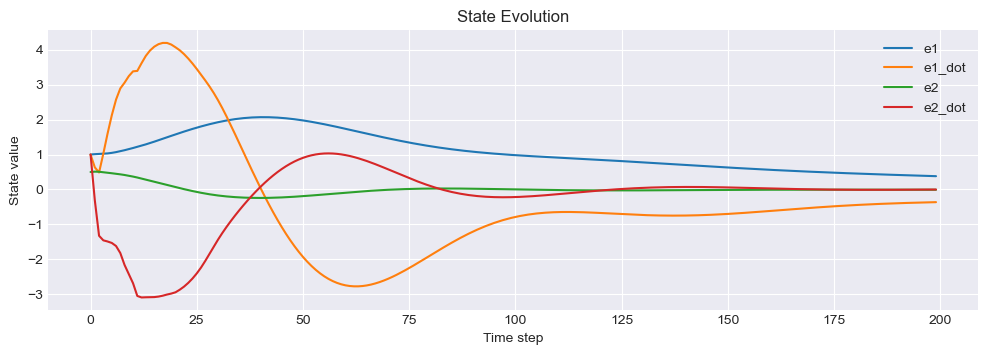

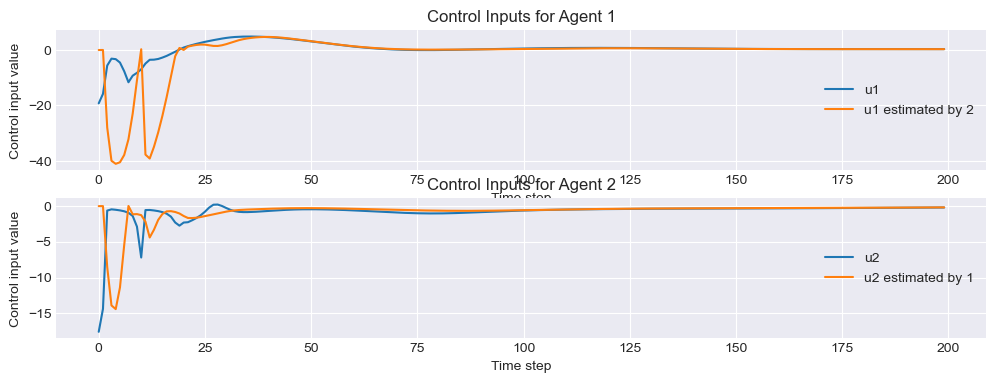

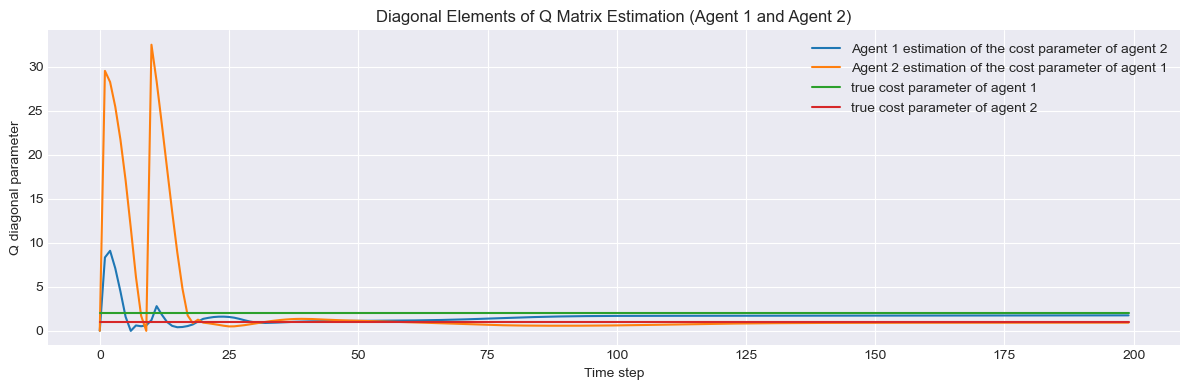

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Updated Example matrices for the shared steering control system (4D system)
A = np.array([[0, 1, 0, 0],
                    [0, -3.608, 144.321, -0.230],
                    [0, 0, 0, 1],
                    [0, -0.170, 6.804, -4.397]], dtype=np.float32)

B1 = np.array([[0],
                [2.848],
                [0],
                [3.516]], dtype=np.float32)

B2 = 1*B1.copy()  # B1 and B2 are the same based on the model

Q1 = 1*np.diag([1, 2, 1, 0.5])  # 4x4 state cost matrix for agent 1
Q2 = 1*np.diag([2, 1, 1, 0.5])  # 4x4 state cost matrix for agent 2
R = np.eye(1)  # 1x1 identity matrix for the control cost

# Initial guesses for the other agent's gain matrices (1x4)
K2_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)
K1_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)

# Initial state (4D vector)
initial_state = 1*np.array([1.0, 1.0, 0.5, 1.0])

# Initialize the environment
env = Environment(initial_state, dt=0.01)

# Initialize agents
agent1 = Agent(A, B1, Q1, B2, 0.5 * Q2, K2_init)  # B2 passed as other agent's input matrix
agent2 = Agent(A, B2, Q2, B1, Q1, K1_init)  # B1 passed as other agent's input matrix

agent1.theta_other = agent1.theta_other*10
agent2.theta_other = agent2.theta_other*10

# Simulation parameters
num_steps = 200

# Data storage for plotting
state_history = []
u1_history = []
u2_history = []
u1_other_history = []
u2_other_history = []
Q1_diag_0_history = []
Q1_diag_1_history = []
Q2_diag_0_history = []  # To store the estimation of Agent 2's theta
Q2_diag_1_history = []

# Reset the environment
state = env.reset()

# Run the simulation
Lya = []
flip_interval = 200
for i in range(20):
    agent1.solve_riccati()
    agent2.solve_riccati()

    agent1.estimate_P_other(agent1.K)
    agent2.estimate_P_other(agent2.K)

#agent1.P_other = agent1.P/2
#agent2.P_other = agent2.P/2
for step in range(num_steps):
    #if step % flip_interval == 0 and step != 0:
        #env.reset()
        #state = env.current_state
        #agent1.reset_history()
        #agent2.reset_history()
        
    agent1.solve_riccati()
    agent2.solve_riccati()
    
    # Get control inputs
    u1 = agent1.get_control_input(state)
    u2 = agent2.get_control_input(state)
    
    # Append the state as a row vector
    state_history.append(state.flatten())  # Ensure state is appended as a 1D row array
    u1_history.append(u1.flatten())  # Ensure control inputs are stored as 1D
    u2_history.append(u2.flatten())
    u1_other_history.append(agent1.u_other.flatten())
    u2_other_history.append(agent2.u_other.flatten())
    
    # Update the state
    agent1.update_state_history(state, u2)
    agent2.update_state_history(state, u1)
    
    # Compute next state
    state = env.next_state(u1, u2)

    # Perform gradient descent updates on theta_other
    agent1.gradient_descent_update()
    agent2.gradient_descent_update()
    print(agent1.theta_other)
    
    #V1 = np.trace((agent1.P_other - agent2.P).T @ (agent1.P_other - agent2.P))
    #Lya.append(V1)
    Q1_diag_0_history.append(agent1.theta_other[0][0])
    Q2_diag_0_history.append(agent2.theta_other[0][0])  # Track Agent 2's estimation
    Q1_diag_1_history.append(Q1[1, 1])
    Q2_diag_1_history.append(Q2[1, 1])

# Convert to numpy arrays for plotting
state_history = np.array(state_history)  # Use vstack to ensure correct 2D shape
u1_history_me = np.array(u1_history)  # Use vstack for consistent 2D shape
u2_history_me = np.array(u2_history)
u1_other_history = np.array(u1_other_history)
u2_other_history = np.array(u2_other_history)

u1_blame_me = u1_history_me
u2_blame_me = u2_history_me
u1_est_blame_me = u1_other_history
u2_est_blame_me = u2_other_history

Q1_diag_0_history_me = Q1_diag_0_history
Q2_diag_0_history_me = Q2_diag_0_history


# Plot state evolution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(state_history[:, 0], label='e1')  # Plot 4D state variables
plt.plot(state_history[:, 1], label='e1_dot')
plt.plot(state_history[:, 2], label='e2')
plt.plot(state_history[:, 3], label='e2_dot')
plt.legend()
plt.title('State Evolution')
plt.xlabel('Time step')
plt.ylabel('State value')

# Plot control inputs
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(u1_history_me[:, 0], label='u1')
plt.plot(u2_other_history[:, 0], label='u1 estimated by 2')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 1')
plt.xlabel('Time step')
plt.ylabel('Control input value')

plt.subplot(2, 1, 2)
plt.plot(u2_history_me[:, 0], label='u2')
plt.plot(u1_other_history[:, 0], label='u2 estimated by 1')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 2')
plt.xlabel('Time step')
plt.ylabel('Control input value')

# Plot diagonal elements of Q matrix of Agent 1 and Agent 2's estimation
plt.figure(figsize=(12, 4))
plt.plot(Q1_diag_0_history, label='Agent 1 estimation of the cost parameter of agent 2')
plt.plot(Q2_diag_0_history, label='Agent 2 estimation of the cost parameter of agent 1')  # Agent 2 estimation
plt.plot(Q1_diag_1_history, label='true cost parameter of agent 1')
plt.plot(Q2_diag_1_history, label='true cost parameter of agent 2')
plt.legend()
plt.title('Diagonal Elements of Q Matrix Estimation (Agent 1 and Agent 2)')
plt.xlabel('Time step')
plt.ylabel('Q diagonal parameter')

plt.tight_layout()
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

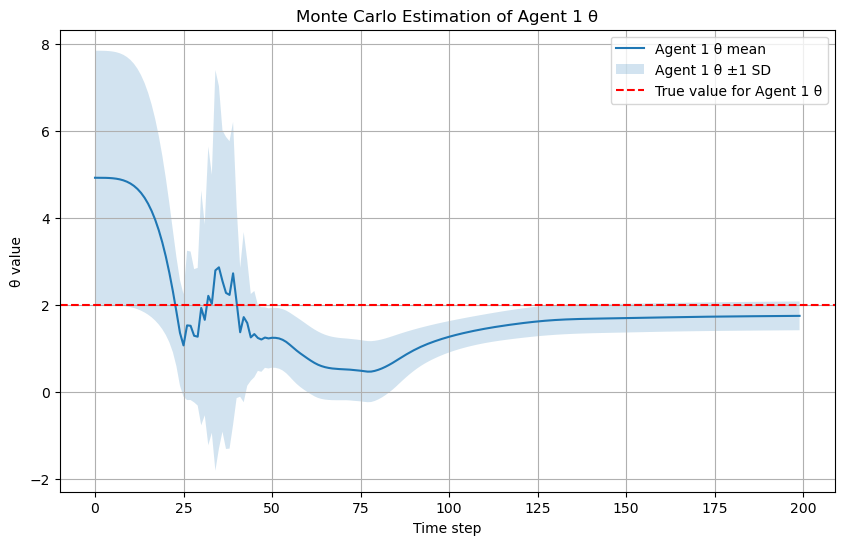

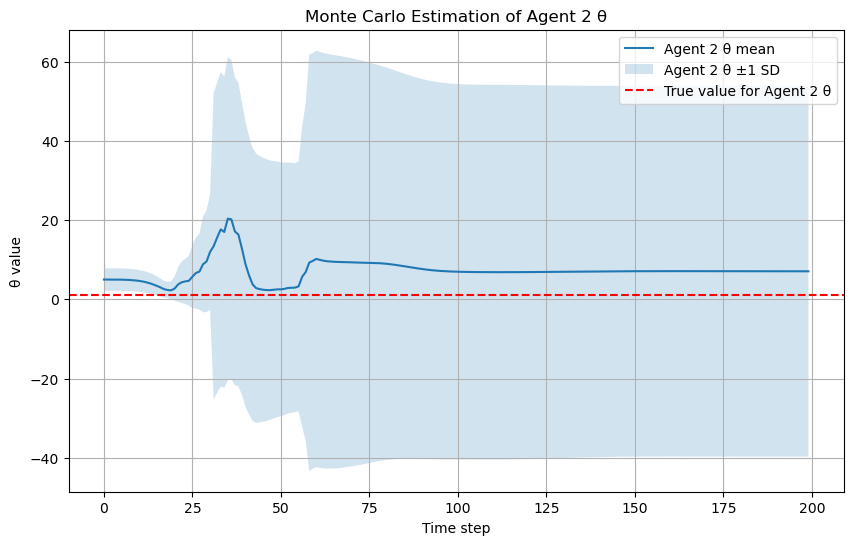

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected Shared Steering Example matrices for 4D system based on vx = 20 m/s
A = np.array([[0, 1, 0, 0],
              [0, -3.608, 144.321, -0.230],
              [0, 0, 0, 1],
              [0, -0.170, 6.804, -4.397]], dtype=np.float32)

B1 = np.array([[0],
               [2.848],
               [0],
               [3.516]], dtype=np.float32)

B2 = 1 * B1.copy()  # B1 and B2 are the same based on the model

Q1 = np.diag([1, 2, 1, 0.5])  # 4x4 state cost matrix for agent 1
Q2 = np.diag([2, 1, 1, 0.5])  # 4x4 state cost matrix for agent 2
R = np.eye(1)  # 1x1 identity matrix for the control cost

# Initial guesses for the other agent's gain matrices (1x4)
K2_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)
K1_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)

# Initial state (4D vector)
initial_state = np.array([1.0, 1.0, 0.5, 1.0])

# Simulation parameters
num_steps = 200
num_mc_iterations = 500  # Monte Carlo iterations

# Data storage for Monte Carlo results
agent1_estimations_all_blame_me = []
agent2_estimations_all_blame_me = []

# Monte Carlo sampling loop
for mc_iteration in range(num_mc_iterations):
    print(mc_iteration)
    # Initialize the environment and agents
    env = Environment(initial_state, dt=0.01)
    agent1 = Agent(A, B1, Q1, B2, 0.5 * Q2, K2_init)  # B2 passed as other agent's input matrix
    agent2 = Agent(A, B2, Q2, B1, Q1, K1_init)  # B1 passed as other agent's input matrix

    # Randomly scale theta_other (scalar)
    random_scale1 = np.random.uniform(0, 10)
    random_scale2 = np.random.uniform(0, 10)
    
    agent1.theta_other *= random_scale1*agent1.theta_other
    agent2.theta_other *= random_scale2*agent2.theta_other
    

    # Data storage for this iteration
    Q1_diag_0_history = []
    Q2_diag_0_history = []
    Q1_diag_1_history = []  # True value for Agent 1
    Q2_diag_1_history = []  # True value for Agent 2

    # Reset environment
    state = env.reset()

    for i in range(50):
        agent1.solve_riccati()
        agent2.solve_riccati()
        agent1.estimate_P_other(agent1.K)
        agent2.estimate_P_other(agent2.K)

    flip_interval = 400

    # Run the simulation for `num_steps`
    for step in range(num_steps):
        #if step % flip_interval == 0 and step != 0:
            #env.reset()
            #state = env.current_state
            #agent1.reset_history()
            #agent2.reset_history()

        agent1.solve_riccati()
        agent2.solve_riccati()

        # Get control inputs
        u1 = agent1.get_control_input(state)
        u2 = agent2.get_control_input(state)

        # Update the state
        state = env.next_state(1 * u1, 1 * u2)

        # Update state histories in agents
        agent1.update_state_history(state, u2)
        agent2.update_state_history(state, u1)

        # Perform gradient descent updates on theta_other
        agent1.gradient_descent_update()
        agent2.gradient_descent_update()

        # Store the estimations (as scalars)
        Q1_diag_0_history.append(agent1.theta_other.item())  # Scalar value
        Q2_diag_0_history.append(agent2.theta_other.item())  # Scalar value

        # Store true values for plotting
        Q1_diag_1_history.append(1.0)  # True theta value for Agent 1
        Q2_diag_1_history.append(2.0)  # True theta value for Agent 2

    # Store results for this Monte Carlo iteration
    agent1_estimations_all_blame_me.append(Q1_diag_0_history)
    agent2_estimations_all_blame_me.append(Q2_diag_0_history)

# Convert results to numpy arrays for analysis
agent1_estimations_all_blame_me = np.array(agent1_estimations_all_blame_me)  # Shape: (num_mc_iterations, num_steps)
agent2_estimations_all_blame_me = np.array(agent2_estimations_all_blame_me)

# Compute mean and standard deviation
agent1_mean_blame_me = np.mean(agent1_estimations_all_blame_me, axis=0)  # Shape: (num_steps,)
agent1_std_blame_me = np.std(agent1_estimations_all_blame_me, axis=0)
agent2_mean_blame_me = np.mean(agent2_estimations_all_blame_me, axis=0)
agent2_std_blame_me = np.std(agent2_estimations_all_blame_me, axis=0)

# Plot results for Agent 1
plt.figure(figsize=(10, 6))
plt.plot(agent1_mean_blame_me, label='Agent 1 θ mean')
plt.fill_between(
    range(num_steps),
    agent1_mean_blame_me - agent1_std_blame_me,
    agent1_mean_blame_me + agent1_std_blame_me,
    alpha=0.2,
    label='Agent 1 θ ±1 SD'
)
plt.axhline(y=2.0, color='r', linestyle='--', label='True value for Agent 1 θ')
plt.title('Monte Carlo Estimation of Agent 1 θ')
plt.xlabel('Time step')
plt.ylabel('θ value')
plt.legend()
plt.grid()
plt.show()

# Plot results for Agent 2
plt.figure(figsize=(10, 6))
plt.plot(agent2_mean_blame_me, label='Agent 2 θ mean')
plt.fill_between(
    range(num_steps),
    agent2_mean_blame_me - agent2_std_blame_me,
    agent2_mean_blame_me + agent2_std_blame_me,
    alpha=0.2,
    label='Agent 2 θ ±1 SD'
)
plt.axhline(y=1.0, color='r', linestyle='--', label='True value for Agent 2 θ')
plt.title('Monte Carlo Estimation of Agent 2 θ')
plt.xlabel('Time step')
plt.ylabel('θ value')
plt.legend()
plt.grid()
plt.show()


Starting simulations for N = 1
Unstable region recorded for N=1, α=46.51
Starting simulations for N = 2
Unstable region recorded for N=2, α=27.009999999999998
Starting simulations for N = 3
Unstable region recorded for N=3, α=18.009999999999998
Starting simulations for N = 4
Unstable region recorded for N=4, α=18.009999999999998
Starting simulations for N = 5
Unstable region recorded for N=5, α=13.51
Starting simulations for N = 6
Unstable region recorded for N=6, α=11.01
Starting simulations for N = 7
Unstable region recorded for N=7, α=10.01
Starting simulations for N = 8
Unstable region recorded for N=8, α=8.01
Starting simulations for N = 9
Unstable region recorded for N=9, α=8.01
Starting simulations for N = 10
Unstable region recorded for N=10, α=7.01
Starting simulations for N = 11
Unstable region recorded for N=11, α=5.1099999999999985
Starting simulations for N = 12
Unstable region recorded for N=12, α=2.610000000000001
Starting simulations for N = 13
Unstable region recorded 

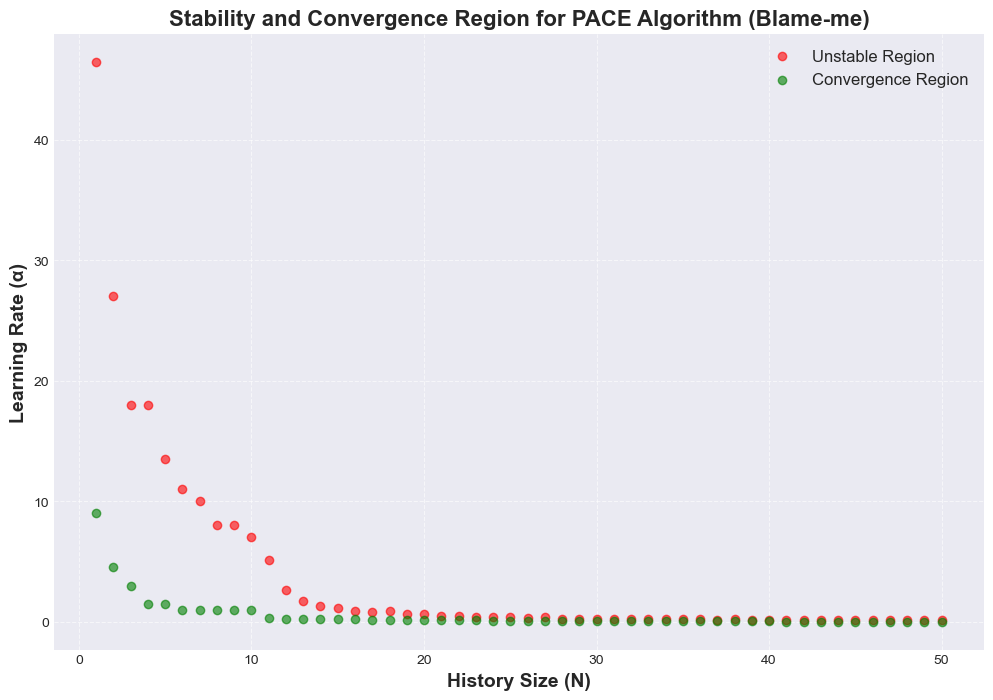

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected Shared Steering Example matrices for 4D system based on vx = 20 m/s
A = np.array([[0, 1, 0, 0],
              [0, -3.608, 144.321, -0.230],
              [0, 0, 0, 1],
              [0, -0.170, 6.804, -4.397]], dtype=np.float32)

B1 = np.array([[0],
               [2.848],
               [0],
               [3.516]], dtype=np.float32)

B2 = 1 * B1.copy()  # B1 and B2 are the same based on the model

Q1 = np.diag([1, 2, 1, 0.5])  # 4x4 state cost matrix for agent 1
Q2 = np.diag([2, 1, 1, 0.5])  # 4x4 state cost matrix for agent 2

# Initial guesses for the other agent's gain matrices (1x4)
K2_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)
K1_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)

# Initial state (4D vector)
initial_state = np.array([1.0, 1.0, 0.5, 1.0])

# Simulation parameters
num_steps = 500

# Ranges for history size (N)
history_sizes = range(1, 51)  # N = 1 to 50

# To store stability and convergence results
stable_region_blame_me = []
convergence_region_blame_me = []

# Loop through history sizes (N)
for N in history_sizes:
    print(f"Starting simulations for N = {N}")
    alpha = 0.01  # Initialize learning rate
    convergence_found = False  # Track if convergence is found for this N

    while True:
        # Initialize agents with current N and α
        agent1 = Agent(A, B1, Q1, B2, 0.5 * Q2, K2_init, history_size=N, learning_rate=alpha)
        agent2 = Agent(A, B2, Q2, B1, Q1, K1_init, history_size=N, learning_rate=alpha)

        # Reset the environment
        env = Environment(initial_state, dt=0.01)
        state = env.reset()

        # Reset θ estimates
        agent1.theta_other = np.zeros_like(agent1.theta_other)  # Start with zero estimate
        agent2.theta_other = np.zeros_like(agent2.theta_other)

        # Pre-simulation Riccati solving
        for i in range(50):
            agent1.solve_riccati()
            agent2.solve_riccati()
            agent1.estimate_P_other(agent1.K)
            agent2.estimate_P_other(agent2.K)

        unstable = False  # To track instability

        # Run the simulation
        for step in range(num_steps):
            agent1.solve_riccati()
            agent2.solve_riccati()

            # Get control inputs
            u1 = agent1.get_control_input(state)
            u2 = agent2.get_control_input(state)

            # Update the state
            state = env.next_state(u1, u2)

            # Update state histories in agents
            agent1.update_state_history(state, u2)
            agent2.update_state_history(state, u1)

            # Perform gradient descent updates on θ
            agent1.gradient_descent_update()
            agent2.gradient_descent_update()

            # Check for instability
            if agent1.theta_other.item() > 10 or agent2.theta_other.item() > 10:
                unstable = True
                break

        # Record stability status
        if unstable:
            stable_region_blame_me.append((N, alpha))
            print(f"Unstable region recorded for N={N}, α={alpha}")
            break

        # Check for convergence if the simulation completed
        if step == num_steps - 1:
            theta1_error = abs(agent1.theta_other.item() - 2.0)  # True value for Agent 1's θ
            theta2_error = abs(agent2.theta_other.item() - 1.0)  # True value for Agent 2's θ

            if theta1_error < 0.8 and theta2_error < 0.8 and not convergence_found:
                convergence_region_blame_me.append((N, alpha))
                convergence_found = True  # Mark convergence as found for this N

        # Adjust α step size dynamically based on N and α
        if N <= 5:
            alpha += 1.5
        elif 5 < N <= 10:
            alpha += 1
        elif 10 < N <= 20:
            alpha += 0.1
        elif 20 < N <= 30:
            alpha += 0.05
        elif 30< N <= 40:
            alpha += 0.02
        else:
            alpha += 0.01

# Save results for analysis
stable_region_blame_me = np.array(stable_region_blame_me)
convergence_region_blame_me = np.array(convergence_region_blame_me)

# Plot the stable and unstable regions
plt.figure(figsize=(12, 8))
plt.scatter(stable_region_blame_me[:, 0], stable_region_blame_me[:, 1], color='red', label='Unstable Region', alpha=0.6)
if len(convergence_region_blame_me) > 0:
    plt.scatter(convergence_region_blame_me[:, 0], convergence_region_blame_me[:, 1], color='green', label='Convergence Region', alpha=0.6)
plt.xlabel('History Size (N)', fontsize=14, fontweight='bold')
plt.ylabel('Learning Rate (α)', fontsize=14, fontweight='bold')
plt.title('Stability and Convergence Region for PACE Algorithm (Blame-me)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


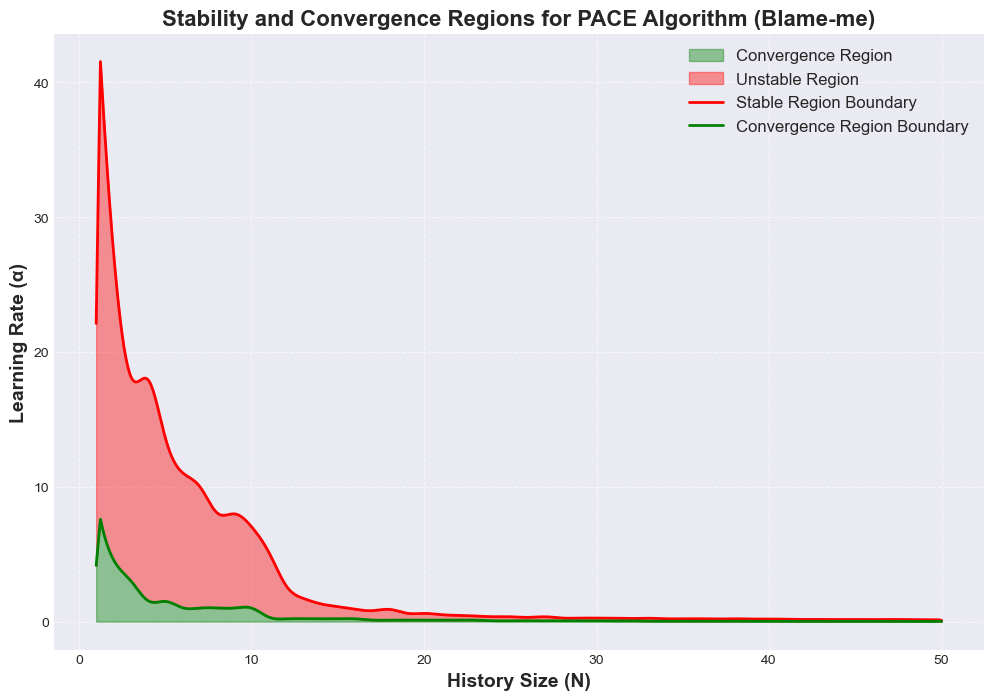

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Assuming stable_region_blame_me and convergence_region_blame_me are numpy arrays
# Shape: (num_points, 2) where each row is [N, α]

# Fit smooth curves to the stable and convergence regions
stable_N = stable_region_blame_me[:, 0]
stable_alpha = stable_region_blame_me[:, 1]
convergence_N = convergence_region_blame_me[:, 0]
convergence_alpha = convergence_region_blame_me[:, 1]

# Use spline interpolation for a smooth trend (degree k=4 for quartic spline)
stable_spline = make_interp_spline(stable_N, stable_alpha, k=3)
convergence_spline = make_interp_spline(convergence_N, convergence_alpha, k=3)

# Generate finer data points for smooth plotting
N_fine = np.linspace(1, 50, 1000)  # Increased resolution for smoother plot
stable_alpha_fine = stable_spline(N_fine)
convergence_alpha_fine = convergence_spline(N_fine)

# Define a moving average function
def moving_average(data, window_size=10):
    """
    Apply a moving average smoothing filter to the data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Apply moving average smoothing to the interpolated data
stable_alpha_fine_smoothed = moving_average(stable_alpha_fine, window_size=10)
convergence_alpha_fine_smoothed = moving_average(convergence_alpha_fine, window_size=10)

# Save the smoothed boundaries data
stable_boundary_data = np.vstack((N_fine, stable_alpha_fine_smoothed)).T
convergence_boundary_data = np.vstack((N_fine, convergence_alpha_fine_smoothed)).T

# Save to CSV files
np.savetxt("stable_boundary_blame_me.csv", stable_boundary_data, delimiter=",", header="N,alpha", comments="")
np.savetxt("convergence_boundary_blame_me.csv", convergence_boundary_data, delimiter=",", header="N,alpha", comments="")

# Plot the regions and fitted curves
plt.figure(figsize=(12, 8))

# Fill the convergence region (green)
plt.fill_between(N_fine, 0, convergence_alpha_fine_smoothed, color='green', alpha=0.4, label='Convergence Region')

# Fill the stable (but not convergent) region (red)
plt.fill_between(N_fine, convergence_alpha_fine_smoothed, stable_alpha_fine_smoothed, color='red', alpha=0.4, label='Unstable Region')

# Plot the fitted curves
plt.plot(N_fine, stable_alpha_fine_smoothed, color='red', linewidth=2, label='Stable Region Boundary')
plt.plot(N_fine, convergence_alpha_fine_smoothed, color='green', linewidth=2, label='Convergence Region Boundary')

# Add labels and title
plt.xlabel('History Size (N)', fontsize=14, fontweight='bold')
plt.ylabel('Learning Rate (α)', fontsize=14, fontweight='bold')
plt.title('Stability and Convergence Regions for PACE Algorithm (Blame-me)', fontsize=16, fontweight='bold')

# Add legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [38]:
print(stable_region)

[]


In [41]:
import numpy as np
from scipy.linalg import solve_continuous_are, solve_continuous_lyapunov

class AgentBlameAll:
    def __init__(self, A, B, Q_actual, other_agent_B, Q_other,Q0, other_agent_K_init, dt=0.01, learning_rate=0.15, history_size=35):
        """
        Initializes the agent with system matrices and cost matrices.
        """
        self.A = A
        self.B = B
        self.Q_actual = Q_actual  # This is the actual Q of the first agent (Agent 1's true objective)
        self.R = np.eye(B.shape[1])  # Custom R matrix for control
        self.other_agent_B = other_agent_B
        self.other_agent_K = other_agent_K_init
        self.K_self_for_other = other_agent_K_init
        self.u_other = 0

        self.dt = dt
        self.P = np.eye(A.shape[0])  # Initialize the Riccati matrix P
        self.K = None
        self.history_size = history_size
        self.state_history = []
        self.u_self_history = []  # History for Agent 1's inputs
        self.K_history = []
        self.u_other_history = []  # History for Agent 2's inputs
        self.other_agent_K_history = []
        self.K_self_for_other_history = []
        self.Q0_other=Q_other
        self.Q0 = Q0

        # Initialize theta for both agents as vectors (one theta per diagonal element of Q)
        self.theta_self = np.random.uniform(0.0015001, 0.0015101001)  # Initial guess for self.theta
        self.theta_other = np.random.uniform(0.0015001, 0.0015101001)  # Initial guess for theta_other

        # Initial Riccati matrices for both agents
        self.P_other = np.eye(A.shape[0])  # Initial Riccati matrix for the other agent
        self.P_self_for_other = np.eye(A.shape[0])  # Agent's guess of the Riccati matrix the other agent is using to estimate their gain
        self.learning_rate = learning_rate

    def solve_riccati(self):
        """
        Solves the Riccati equation for control based on the actual Q of the first agent and
        the current estimate of the other agent's gain.
        """
        A_eff_self = self.A - self.other_agent_B @ self.other_agent_K  # Effective dynamics for self
        try:
            P_self = solve_continuous_are(A_eff_self, self.B, self.Q_actual, self.R)  # Solve ARE using the actual Q of the first agent
            self.P = P_self
            self.K = self.B.T @ P_self  # Control gain for self
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for control")
            self.P = np.eye(self.A.shape[0]) * 0.01
            self.K = np.zeros((self.B.shape[1], self.A.shape[0]))

    def estimate_P_other(self, K_self_est):
        """
        Solves the Riccati equation for the other agent to estimate P_other based on theta_other (vector).
        The Riccati equation for the other agent uses the current K_self of this agent.
        """
        Q_other = self.Q0_other * self.theta_other  # Diagonal matrix for the other agent's Q
        A_eff_other = self.A - self.B @ K_self_est  # The other agent assumes they know our current K_self
        try:
            P_other = solve_continuous_are(A_eff_other, self.other_agent_B, Q_other, self.R)  # Solving ARE for the other agent
            self.P_other = P_other
            self.other_agent_K = self.other_agent_B.T @ P_other  # Gain for the other agent
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for other agent")
            self.P_other = np.eye(self.A.shape[0]) * 0.01
            self.other_agent_K = np.zeros((self.other_agent_B.shape[1], self.A.shape[0]))

    def estimate_P_self_for_other(self, other_K_est):
        """
        Solves the Riccati equation for how the other agent is estimating the self agent.
        The Riccati equation models how the other agent is solving for this agent's gain K_self using its own theta_self estimate.
        """
        Q_self_for_other = self.Q0 * self.theta_self  # Estimate of self's Q from other agent's perspective
        A_eff_self_for_other = self.A - self.other_agent_B @ other_K_est  # Use the other agent's current gain estimation of self
        try:
            P_self_for_other = solve_continuous_are(A_eff_self_for_other, self.B, Q_self_for_other, self.R)  # Solve ARE for how the other agent sees self
            self.P_self_for_other = P_self_for_other
            self.K_self_for_other = self.B.T @ P_self_for_other  # Estimate of self's gain from other agent's perspective
        except np.linalg.LinAlgError:
            print("Error in solving Riccati equation for self as seen by other agent")
            self.P_self_for_other = np.eye(self.A.shape[0]) * 0.01
            self.K_self_for_other = np.zeros((self.B.shape[1], self.A.shape[0]))

    def compute_dP_self_dtheta(self, other_K_est):
        """
        Computes dP_self/dtheta for the given theta index by solving the Lyapunov equation.
        """
        A_eff_self = self.A - self.other_agent_B @ other_K_est
        A_lya_self = A_eff_self - self.B @ self.B.T @ self.P_self_for_other

        dP_self_dtheta = solve_continuous_lyapunov(A_lya_self.T, self.Q0)
        return dP_self_dtheta

    def compute_dP_other_dtheta(self, K_self_est):
        """
        Computes dP_other/dtheta_other for the given theta index by solving the Lyapunov equation for the other agent.
        """
        A_eff_other = self.A - self.B @ K_self_est  # Using the other agent's estimation of our gain
        A_lya_other = A_eff_other - self.other_agent_B @ self.other_agent_B.T @ self.P_other

        dP_other_dtheta = solve_continuous_lyapunov(A_lya_other.T, self.Q0_other)
        return dP_other_dtheta

    def get_control_input(self, state):
        """
        Computes the control input given the current state.
        Uses the gain matrix K derived from the Riccati equation solution.
        """
        if self.K is None:
            raise ValueError("K matrix has not been computed. Call solve_riccati() first.")
        self.u_other = -self.other_agent_K @ state
        control_signal = -self.K @ state
        return control_signal

    def update_state_history(self, state, u_self, u_other):
        """
        Updates the state history with the latest state and the control inputs (both self and other agent).
        """
        if len(self.state_history) > self.history_size:
            self.state_history.pop(0)
            self.u_self_history.pop(0)
            self.u_other_history.pop(0)
            self.K_history.pop(0)
            self.other_agent_K_history.pop(0)
            self.K_self_for_other_history.pop(0)

        self.state_history.append(state)
        self.u_self_history.append(u_self)
        self.u_other_history.append(u_other)
        self.K_history.append(self.K)
        self.other_agent_K_history.append(self.other_agent_K)
        self.K_self_for_other_history.append(self.K_self_for_other)
    
    def reset_history(self):
        self.state_history = []
        self.K_history = []
        self.u_other_history = []
        self.K_self_for_other_history = []
        self.other_agent_K_history = []
        
    def simulate_trajectory_and_compute_error(self):
        """
        Simulates the trajectory with the estimated parameters for both agents, computing the error 
        between the estimated and actual trajectories based on stored states.
        """
        error_sum_self = 0
        error_sum_other = 0

        estimated_state_self = self.state_history[0]
        estimated_state_other = self.state_history[0]

        d_error_dtheta_self = np.zeros_like(estimated_state_self)
        d_error_dtheta_other = np.zeros_like(estimated_state_self)
        
        error_self = self.state_history[0] - self.state_history[0]
        error_other = self.state_history[0] - self.state_history[0]

        for i in range(1,len(self.state_history)):
            # Update K_self and P_other based on history
            self.estimate_P_self_for_other(self.other_agent_K_history[i-1])
            self.estimate_P_other(self.K_self_for_other_history[i-1])

            # Compute controls
            u_self = -self.K_history[i-1] @ self.state_history[i-1]
            #u_self = self.u_self_history[i-1]
            u_other_predicted_self = -self.other_agent_K @ self.state_history[i-1]
            u_self_other = -self.K_self_for_other@self.state_history[i-1]
            

            estimated_state_self = estimated_state_self + self.dt * (self.A @ estimated_state_self + self.B @ u_self + self.other_agent_B @ u_other_predicted_self)
            

            error_other = self.state_history[i] - estimated_state_self
            d_error_self = self.A@error_self + self.B@(-u_self_other+u_self)
            error_self = error_self + self.dt*d_error_self

            #for j in range(len(self.theta_self)):
            dP_self_dtheta_j = self.compute_dP_self_dtheta(self.other_agent_K_history[i-1])
            du_self_dtheta_j = -self.B.T @ dP_self_dtheta_j @ self.state_history[i-1] #-self.B.T @ self.P_self_for_other @ d_error_dtheta_self[j] 
            d_error_dot_dtheta_self = self.A @ d_error_dtheta_self + self.B @ du_self_dtheta_j
            d_error_dtheta_self = d_error_dtheta_self + self.dt * d_error_dot_dtheta_self
            error_sum_self += 1*error_self.T @ d_error_dtheta_self

            dP_other_dtheta_j = self.compute_dP_other_dtheta(self.K_self_for_other_history[i-1])
            du_other_dtheta_j = -self.other_agent_B.T @ dP_other_dtheta_j @ self.state_history[i-1] #- self.other_agent_B.T @ self.P_other @ d_error_dtheta_other[j]
            d_error_dot_dtheta_other = self.A @ d_error_dtheta_other + self.other_agent_B @ du_other_dtheta_j
            d_error_dtheta_other = d_error_dtheta_other + self.dt * d_error_dot_dtheta_other
            error_sum_other += 1*error_other.T @ d_error_dtheta_other

            #estimated_state_self = next_estimated_state_self
            #estimated_state_other = next_estimated_state_other

        return error_sum_self, error_sum_other

    def gradient_descent_update(self):
        """
        Updates theta_self and theta_other using gradient descent based on the recomputed errors.
        """
        error_sum_self, error_sum_other = self.simulate_trajectory_and_compute_error()
        self.theta_self -= self.learning_rate * error_sum_self/self.history_size
        self.theta_other -= self.learning_rate * error_sum_other/self.history_size
        self.theta_self = np.maximum(self.theta_self, 1e-6)
        self.theta_other = np.maximum(self.theta_other, 1e-6)

        self.estimate_P_self_for_other(self.other_agent_K)
        self.estimate_P_other(self.K_self_for_other)


[[0.07068397 0.01917356 1.4254853  0.17181145]]
[[0.07068397 0.01917356 1.4254853  0.17181145]]
0.015027819806073348
0.015027819806073348
[[0.02046228]]
[[0.04059292]]
[[0.07306362]]
[[0.11348074]]
[[0.16013367]]
[[0.21204525]]
[[0.26851316]]
[[0.3289848]]
[[0.39300618]]
[[0.46019264]]
[[0.5302078]]
[[0.6027462]]
[[0.67751786]]
[[0.75423408]]
[[0.83259426]]
[[0.91227377]]
[[0.99291301]]
[[1.07410823]]
[[1.15540443]]
[[1.23629108]]
[[1.31620124]]
[[1.39451482]]
[[1.47056667]]
[[1.54366]]
[[1.61308556]]
[[1.67814666]]
[[1.73818963]]
[[1.79263872]]
[[1.84103375]]
[[1.88306764]]
[[1.91862013]]
[[1.94778273]]
[[1.97086943]]
[[1.98840784]]
[[2.00110707]]
[[2.00872279]]
[[2.01405632]]
[[2.01634696]]
[[2.01704172]]
[[2.01716916]]
[[2.01694443]]
[[2.01658317]]
[[2.01620306]]
[[2.01585595]]
[[2.01556449]]
[[2.01533563]]
[[2.0151686]]
[[2.01505925]]
[[2.0150016]]
[[2.01498896]]
[[2.01501422]]
[[2.0150702]]
[[2.01514966]]
[[2.01524537]]
[[2.0153502]]
[[2.01545711]]
[[2.01555927]]
[[2.01565009]]
[[

C:\ProgramData\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


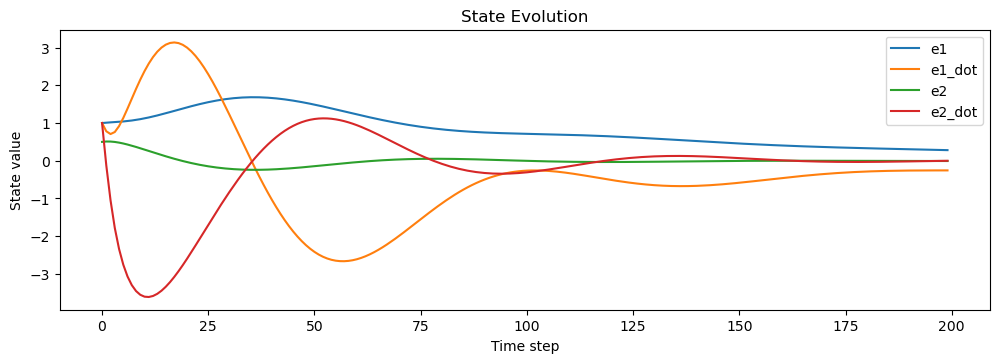

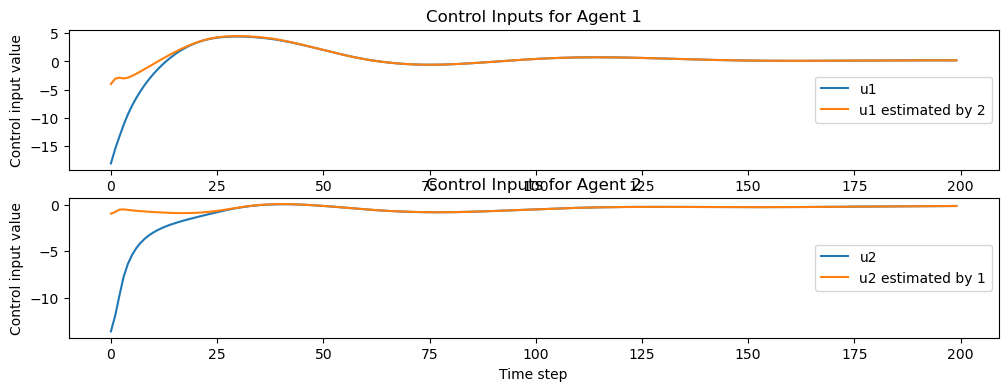

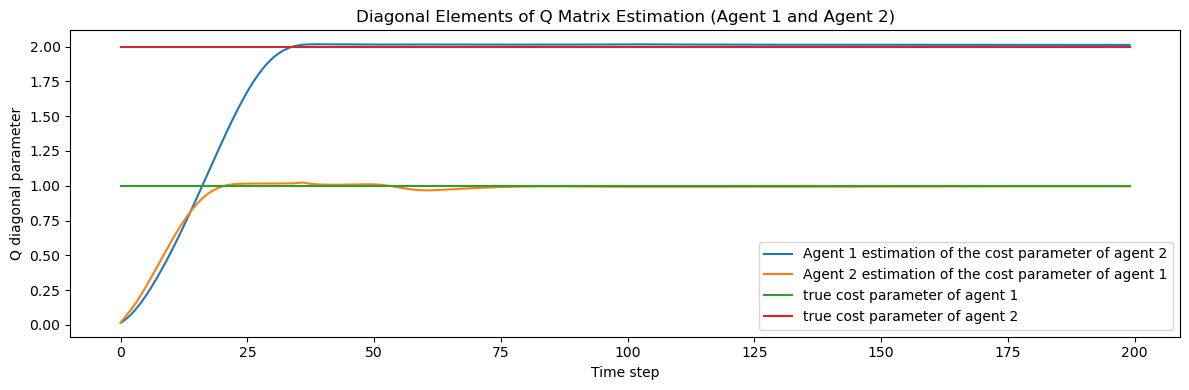

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected Shared Steering Example matrices for 4D system based on vx = 20 m/s
A = np.array([[0, 1, 0, 0],
                    [0, -3.608, 144.321, -0.230],
                    [0, 0, 0, 1],
                    [0, -0.170, 6.804, -4.397]], dtype=np.float32)

B1 = np.array([[0],
                [2.848],
                [0],
                [3.516]], dtype=np.float32)

B2 = 1*B1.copy()  # B1 and B2 are the same based on the model

Q1 = np.diag([1, 2, 1, 0.5])  # 4x4 state cost matrix for agent 1
Q2 = np.diag([2, 1, 1, 0.5])  # 4x4 state cost matrix for agent 2
R = np.eye(1)  # 1x1 identity matrix for the control cost

# Initial guesses for the other agent's gain matrices (1x4)
K2_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)
K1_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)

# Initial state (4D vector)
initial_state = np.array([1.0, 1.0, 0.5, 1.0])

# Initialize the environment
env = Environment(initial_state, dt=0.01)

# Initialize agents
agent1 = AgentBlameAll(A, B1, Q1, B2, 0.5 * Q2, Q1, K2_init)  # B2 passed as other agent's input matrix
agent2 = AgentBlameAll(A, B2, Q2, B1, Q1, 0.5 * Q2, K1_init)  # B1 passed as other agent's input matrix

agent1.theta_other = agent1.theta_other*10
agent2.theta_other = agent2.theta_other*10

agent1.theta_self = agent2.theta_other
agent2.theta_self = agent1.theta_other

# Simulation parameters
num_steps = 200

# Data storage for plotting
state_history = []
u1_history = []
u2_history = []
u1_other_history = []
u2_other_history = []
Q1_diag_0_history = []
Q1_diag_1_history = []
Q2_diag_0_history = []  # To store the estimation of Agent 2's theta
Q2_diag_1_history = []

# Reset the environment
state = env.reset()

# Run the simulation
agent1.solve_riccati()
agent2.solve_riccati()
lya = []
flip_interval = 400

for i in range(50):
    agent1.estimate_P_self_for_other(agent1.other_agent_K)
    agent2.estimate_P_self_for_other(agent2.other_agent_K)
    agent1.estimate_P_other(agent1.K_self_for_other)
    agent2.estimate_P_other(agent2.K_self_for_other)

print(agent1.other_agent_K)
print(agent2.K_self_for_other)
#print(agent1.theta_other)
#print(agent2.theta_self)



    
for step in range(num_steps):
    if step % flip_interval == 0 and step != 0:
        env.reset()
        state = env.current_state
        agent1.reset_history()
        agent2.reset_history()
    
    agent1.solve_riccati()
    agent2.solve_riccati()
    
    # Get control inputs
    u1 = agent1.get_control_input(state)
    u2 = agent2.get_control_input(state)
    
    # Append the state as a 1D array
    state_history.append(state.copy())  # Store the state as a 1D array
    u1_history.append(u1.flatten())  # Also ensure control inputs are stored as 1D
    u2_history.append(u2.flatten())
    u1_other_history.append(agent1.u_other.flatten())
    u2_other_history.append(agent2.u_other.flatten())

    # Update the state
    agent1.update_state_history(state, u1, u2)
    agent2.update_state_history(state, u2, u1)
    
    state = env.next_state(1 * u1, 1 * u2)

    # Perform gradient descent updates on theta_other
    print(agent1.theta_other)

    agent1.gradient_descent_update()
    agent2.gradient_descent_update()
    Q1_diag_0_history.append(agent1.theta_other)  # Store scalar theta_other values
    Q2_diag_0_history.append(agent2.theta_other)  # Track Agent 2's estimation
    Q1_diag_1_history.append(1.0)  # True theta value for Agent 1
    Q2_diag_1_history.append(2.0)  # True theta value for Agent 2
    # Lya.append(agent1.e[0][0])

# Convert to numpy arrays for plotting
state_history = np.array(state_history)  # Convert to 2D shape
u1_history_all = np.array(u1_history)  # Convert to 2D shape
u2_history_all = np.array(u2_history)
u1_other_history = np.array(u1_other_history)
u2_other_history = np.array(u2_other_history)

u1_blame_all = u1_history_all
u2_blame_all = u2_history_all
u1_est_blame_all = u1_other_history
u2_est_blame_all = u2_other_history

Q1_diag_0_history_all = Q1_diag_0_history
Q2_diag_0_history_all = Q2_diag_0_history

# Plot state evolution
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(state_history[:, 0], label='e1')  # Now state_history is (num_steps, 4)
plt.plot(state_history[:, 1], label='e1_dot')
plt.plot(state_history[:, 2], label='e2')
plt.plot(state_history[:, 3], label='e2_dot')
plt.legend()
plt.title('State Evolution')
plt.xlabel('Time step')
plt.ylabel('State value')

# Plot control inputs
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(u1_history_all[:, 0], label='u1')
plt.plot(u2_other_history[:, 0], label='u1 estimated by 2')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 1')
plt.xlabel('Time step')
plt.ylabel('Control input value')

plt.subplot(2, 1, 2)
plt.plot(u2_history_all[:, 0], label='u2')
plt.plot(u1_other_history[:, 0], label='u2 estimated by 1')
plt.legend(loc='center right')
plt.title('Control Inputs for Agent 2')
plt.xlabel('Time step')
plt.ylabel('Control input value')

# Plot diagonal elements of Q matrix of Agent 1 and Agent 2's estimation
plt.figure(figsize=(12, 4))
plt.plot(Q1_diag_0_history, label='Agent 1 estimation of the cost parameter of agent 2')
plt.plot(Q2_diag_0_history, label='Agent 2 estimation of the cost parameter of agent 1')  # Agent 2 estimation
plt.plot(Q1_diag_1_history, label='true cost parameter of agent 1')
plt.plot(Q2_diag_1_history, label='true cost parameter of agent 2')
plt.legend()
plt.title('Diagonal Elements of Q Matrix Estimation (Agent 1 and Agent 2)')
plt.xlabel('Time step')
plt.ylabel('Q diagonal parameter')

plt.tight_layout()
plt.show()


In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Define plotting function
def save_plots(state_history, u1_history_all, u2_history_all, u1_other_history, u2_other_history, Q1_diag_0_history, Q2_diag_0_history, Q1_diag_1_history, Q2_diag_1_history):
    font_size = 16
    line_width = 2.5

    # Plot state evolution
    plt.figure(figsize=(12, 8))
    for i in range(state_history.shape[1]):
        plt.plot(state_history[:, i], label=f'State {i+1}', linewidth=line_width)
    plt.title('State Evolution', fontsize=font_size)
    plt.xlabel('Time step', fontsize=font_size)
    plt.ylabel('State value', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid()
    plt.tight_layout()
    plt.savefig("state_evolution.png")
    plt.close()

    # Plot control inputs
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(u1_history_all[:, 0], label='u1 (true)', linewidth=line_width)
    plt.plot(u2_other_history[:, 0], label='u1 (predicted by Agent 2)', linewidth=line_width)
    plt.title('Control Inputs for Agent 1', fontsize=font_size)
    plt.xlabel('Time step', fontsize=font_size)
    plt.ylabel('Control input value', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(u2_history_all[:, 0], label='u2 (true)', linewidth=line_width)
    plt.plot(u1_other_history[:, 0], label='u2 (predicted by Agent 1)', linewidth=line_width)
    plt.title('Control Inputs for Agent 2', fontsize=font_size)
    plt.xlabel('Time step', fontsize=font_size)
    plt.ylabel('Control input value', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid()
    plt.tight_layout()
    plt.savefig("control_inputs.png")
    plt.close()

    # Plot parameter estimates
    plt.figure(figsize=(12, 6))
    plt.plot(Q1_diag_0_history, label='Agent 1 estimate of Agent 2 parameter', linewidth=line_width)
    plt.plot(Q2_diag_0_history, label='Agent 2 estimate of Agent 1 parameter', linewidth=line_width)
    plt.plot(Q1_diag_1_history, label='True parameter of Agent 1', linewidth=line_width, linestyle='--')
    plt.plot(Q2_diag_1_history, label='True parameter of Agent 2', linewidth=line_width, linestyle='--')
    plt.title('Parameter Estimation', fontsize=font_size)
    plt.xlabel('Time step', fontsize=font_size)
    plt.ylabel('Parameter value', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid()
    plt.tight_layout()
    plt.savefig("parameter_estimation.png")
    plt.close()

# Assuming data arrays like state_history, u1_history_all, etc., are already available
save_plots(state_history, u1_history_all, u2_history_all, u1_other_history, u2_other_history, 
           Q1_diag_0_history_all, Q2_diag_0_history_all, Q1_diag_1_history, Q2_diag_1_history)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

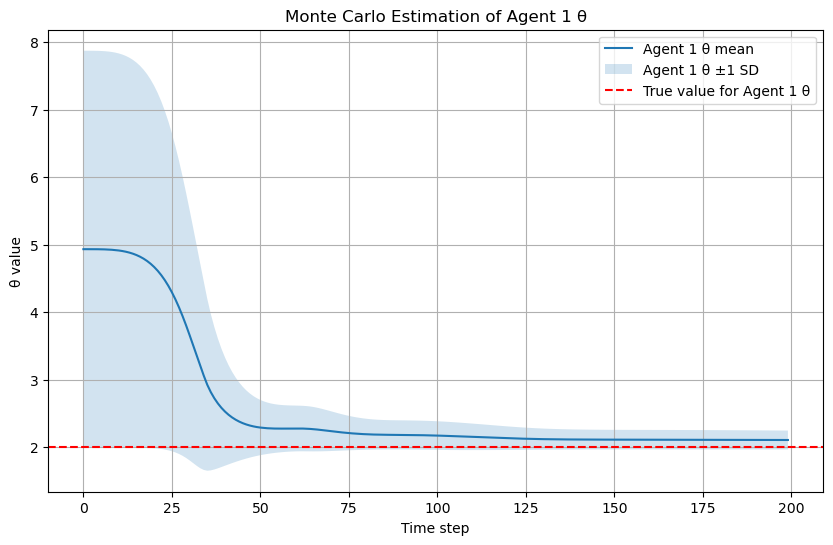

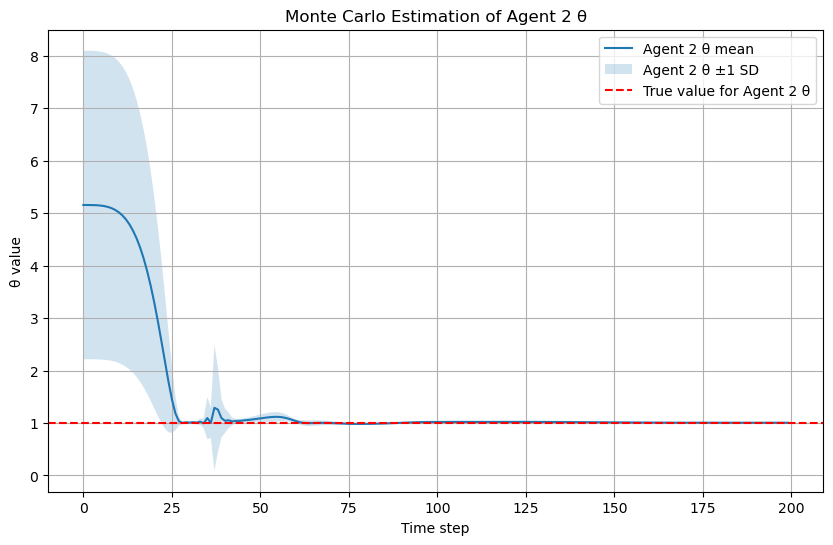

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected Shared Steering Example matrices for 4D system based on vx = 20 m/s
A = np.array([[0, 1, 0, 0],
              [0, -3.608, 144.321, -0.230],
              [0, 0, 0, 1],
              [0, -0.170, 6.804, -4.397]], dtype=np.float32)

B1 = np.array([[0],
               [2.848],
               [0],
               [3.516]], dtype=np.float32)

B2 = 1 * B1.copy()  # B1 and B2 are the same based on the model

Q1 = np.diag([1, 2, 1, 0.5])  # 4x4 state cost matrix for agent 1
Q2 = np.diag([2, 1, 1, 0.5])  # 4x4 state cost matrix for agent 2
R = np.eye(1)  # 1x1 identity matrix for the control cost

# Initial guesses for the other agent's gain matrices (1x4)
K2_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)
K1_init = 0.2 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)

# Initial state (4D vector)
initial_state = np.array([1.0, 1.0, 0.5, 1.0])

# Simulation parameters
num_steps = 200
num_mc_iterations = 500  # Monte Carlo iterations

# Data storage for Monte Carlo results
agent1_estimations_all = []
agent2_estimations_all = []

# Monte Carlo sampling loop
for mc_iteration in range(num_mc_iterations):
    print(mc_iteration)
    # Initialize the environment and agents
    env = Environment(initial_state, dt=0.01)
    agent1 = AgentBlameAll(A, B1, Q1, B2, 0.5 * Q2, Q1, K2_init)
    agent2 = AgentBlameAll(A, B2, Q2, B1, Q1, 0.5 * Q2, K1_init)

    # Randomly scale theta_other (scalar)
    random_scale1 = np.random.uniform(0, 10)
    random_scale2 = np.random.uniform(0, 10)
    
    agent1.theta_other *= random_scale1*agent1.theta_other
    agent2.theta_other *= random_scale2*agent2.theta_other
    
    agent1.theta_self = agent2.theta_other
    agent2.theta_self = agent1.theta_other
    

    # Data storage for this iteration
    Q1_diag_0_history = []
    Q2_diag_0_history = []
    Q1_diag_1_history = []  # True value for Agent 1
    Q2_diag_1_history = []  # True value for Agent 2

    # Reset environment
    state = env.reset()

    for i in range(50):
        agent1.estimate_P_self_for_other(agent1.other_agent_K)
        agent2.estimate_P_self_for_other(agent2.other_agent_K)
        agent1.estimate_P_other(agent1.K_self_for_other)
        agent2.estimate_P_other(agent2.K_self_for_other)

    flip_interval = 400

    # Run the simulation for `num_steps`
    for step in range(num_steps):
        if step % flip_interval == 0 and step != 0:
            env.reset()
            state = env.current_state
            agent1.reset_history()
            agent2.reset_history()

        agent1.solve_riccati()
        agent2.solve_riccati()

        # Get control inputs
        u1 = agent1.get_control_input(state)
        u2 = agent2.get_control_input(state)

        # Update the state
        state = env.next_state(1 * u1, 1 * u2)

        # Update state histories in agents
        agent1.update_state_history(state, u1, u2)
        agent2.update_state_history(state, u2, u1)

        # Perform gradient descent updates on theta_other
        agent1.gradient_descent_update()
        agent2.gradient_descent_update()

        # Store the estimations (as scalars)
        Q1_diag_0_history.append(agent1.theta_other.item())  # Scalar value
        Q2_diag_0_history.append(agent2.theta_other.item())  # Scalar value

        # Store true values for plotting
        Q1_diag_1_history.append(1.0)  # True theta value for Agent 1
        Q2_diag_1_history.append(2.0)  # True theta value for Agent 2

    # Store results for this Monte Carlo iteration
    agent1_estimations_all.append(Q1_diag_0_history)
    agent2_estimations_all.append(Q2_diag_0_history)

# Convert results to numpy arrays for analysis
agent1_estimations_all = np.array(agent1_estimations_all)  # Shape: (num_mc_iterations, num_steps)
agent2_estimations_all = np.array(agent2_estimations_all)

# Compute mean and standard deviation
agent1_mean = np.mean(agent1_estimations_all, axis=0)  # Shape: (num_steps,)
agent1_std = np.std(agent1_estimations_all, axis=0)
agent2_mean = np.mean(agent2_estimations_all, axis=0)
agent2_std = np.std(agent2_estimations_all, axis=0)

# Plot results for Agent 1
plt.figure(figsize=(10, 6))
plt.plot(agent1_mean, label='Agent 1 θ mean')
plt.fill_between(
    range(num_steps),
    agent1_mean - agent1_std,
    agent1_mean + agent1_std,
    alpha=0.2,
    label='Agent 1 θ ±1 SD'
)
plt.axhline(y=2.0, color='r', linestyle='--', label='True value for Agent 1 θ')
plt.title('Monte Carlo Estimation of Agent 1 θ')
plt.xlabel('Time step')
plt.ylabel('θ value')
plt.legend()
plt.grid()
plt.show()

# Plot results for Agent 2
plt.figure(figsize=(10, 6))
plt.plot(agent2_mean, label='Agent 2 θ mean')
plt.fill_between(
    range(num_steps),
    agent2_mean - agent2_std,
    agent2_mean + agent2_std,
    alpha=0.2,
    label='Agent 2 θ ±1 SD'
)
plt.axhline(y=1.0, color='r', linestyle='--', label='True value for Agent 2 θ')
plt.title('Monte Carlo Estimation of Agent 2 θ')
plt.xlabel('Time step')
plt.ylabel('θ value')
plt.legend()
plt.grid()
plt.show()


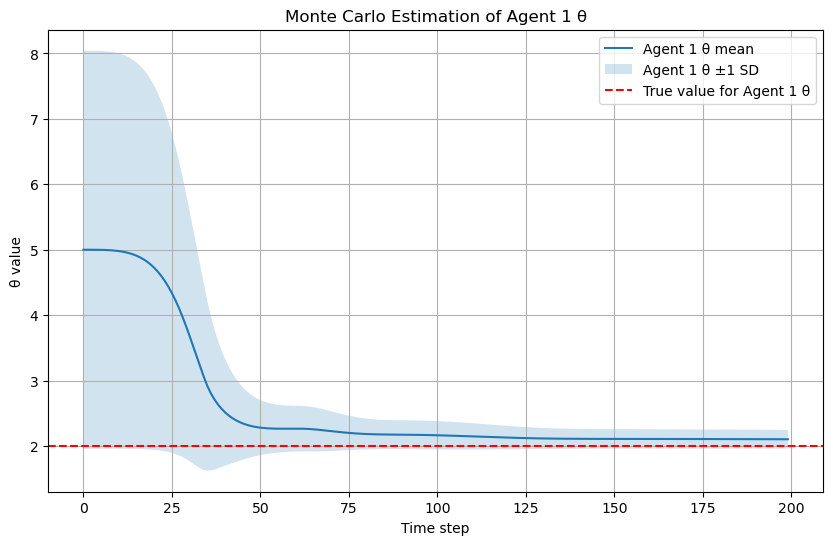

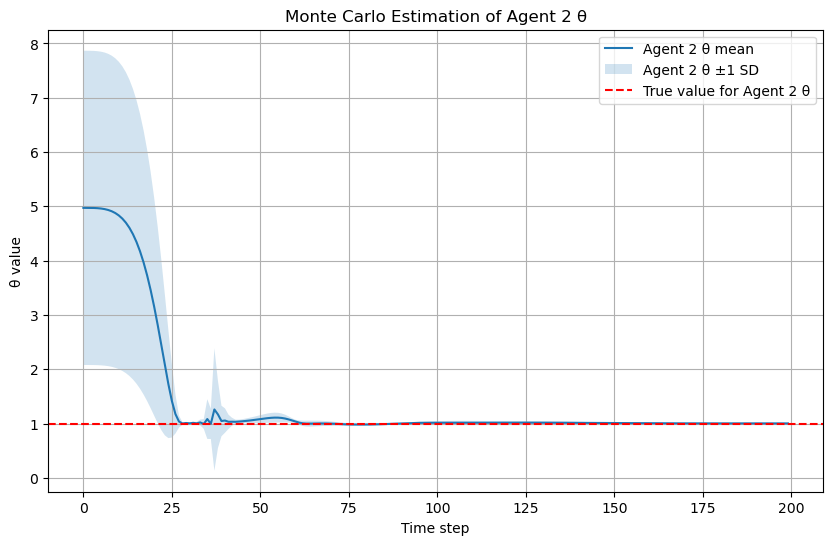

In [8]:
# Plot results for Agent 1
plt.figure(figsize=(10, 6))
plt.plot(agent1_mean, label='Agent 1 θ mean')
plt.fill_between(
    range(num_steps),
    agent1_mean - agent1_std,
    agent1_mean + agent1_std,
    alpha=0.2,
    label='Agent 1 θ ±1 SD'
)
plt.axhline(y=2.0, color='r', linestyle='--', label='True value for Agent 1 θ')
plt.title('Monte Carlo Estimation of Agent 1 θ')
plt.xlabel('Time step')
plt.ylabel('θ value')
plt.legend()
plt.grid()
plt.show()

# Plot results for Agent 2
plt.figure(figsize=(10, 6))
plt.plot(agent2_mean, label='Agent 2 θ mean')
plt.fill_between(
    range(num_steps),
    agent2_mean - agent2_std,
    agent2_mean + agent2_std,
    alpha=0.2,
    label='Agent 2 θ ±1 SD'
)
plt.axhline(y=1.0, color='r', linestyle='--', label='True value for Agent 2 θ')
plt.title('Monte Carlo Estimation of Agent 2 θ')
plt.xlabel('Time step')
plt.ylabel('θ value')
plt.legend()
plt.grid()
plt.show()


Starting simulations for N = 1
[[3.87763025]]
[[10.76953537]]
Unstable region recorded for N=1, α=33.01
Starting simulations for N = 2
[[1.32143747]]
[[16.64679609]]
Unstable region recorded for N=2, α=21.009999999999998
Starting simulations for N = 3
[[1.22641523]]
[[352.8955584]]
Unstable region recorded for N=3, α=21.009999999999998
Starting simulations for N = 4
[[1.80453687]]
[[347.38219915]]
Unstable region recorded for N=4, α=15.01
Starting simulations for N = 5
[[1.76194727]]
[[14.71156961]]
Unstable region recorded for N=5, α=9.01
Starting simulations for N = 6
[[1.88835008]]
[[37.13640134]]
Unstable region recorded for N=6, α=8.01
Starting simulations for N = 7
[[1.82895502]]
[[326.82677066]]
Unstable region recorded for N=7, α=8.01
Starting simulations for N = 8
[[1.81341562]]
[[298.4570123]]
Unstable region recorded for N=8, α=6.01
Starting simulations for N = 9
[[1.74070744]]
[[1512.88446091]]
Unstable region recorded for N=9, α=6.01
Starting simulations for N = 10
[[1.877

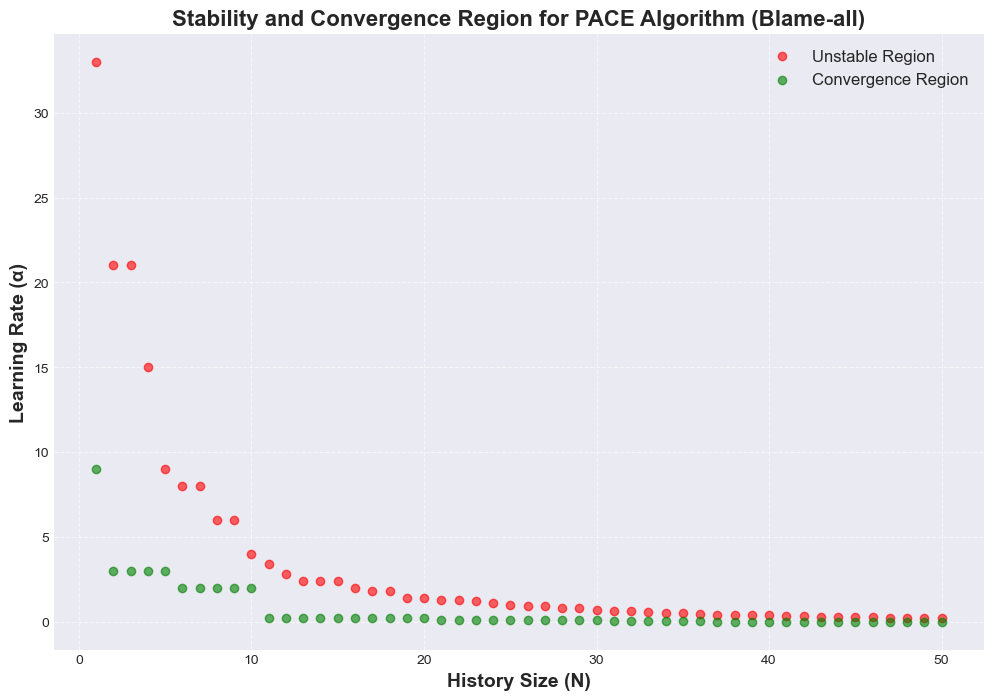

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected Shared Steering Example matrices for 4D system based on vx = 20 m/s
A = np.array([[0, 1, 0, 0],
              [0, -3.608, 144.321, -0.230],
              [0, 0, 0, 1],
              [0, -0.170, 6.804, -4.397]], dtype=np.float32)

B1 = np.array([[0],
               [2.848],
               [0],
               [3.516]], dtype=np.float32)

B2 = 1 * B1.copy()  # B1 and B2 are the same based on the model

Q1 = np.diag([1, 2, 1, 0.5])  # 4x4 state cost matrix for agent 1
Q2 = np.diag([2, 1, 1, 0.5])  # 4x4 state cost matrix for agent 2

# Initial guesses for the other agent's gain matrices (1x4)
K2_init = 0.0 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)
K1_init = 0.0 * np.ones((1, 4))  # 1x4 gain matrix (one input, four states)

# Initial state (4D vector)
initial_state = np.array([1.0, 1.0, 0.5, 1.0])

# Simulation parameters
num_steps = 250

# Ranges for history size (N)
history_sizes = range(1, 51)  # N = 1 to 50

# To store stability and convergence results
stable_region_blame_all = []
convergence_region_blame_all = []

# Loop through history sizes (N)
for N in history_sizes:
    print(f"Starting simulations for N = {N}")
    alpha = 0.01  # Initialize learning rate
    convergence_found = False  # Track if convergence is found for this N

    while True:
        # Initialize agents with current N and α
        agent1 = AgentBlameAll(A, B1, Q1, B2, 0.5 * Q2, Q1, K2_init, history_size=N, learning_rate=alpha)
        agent2 = AgentBlameAll(A, B2, Q2, B1, Q1, 0.5 * Q2, K1_init, history_size=N, learning_rate=alpha)

        # Reset the environment
        env = Environment(initial_state, dt=0.01)
        state = env.reset()

        # Reset θ estimates
        #agent1.theta_other = np.zeros_like(agent1.theta_other)  # Start with zero estimate
        #agent2.theta_other = np.zeros_like(agent2.theta_other)
        #agent1.theta_self = np.zeros_like(agent2.theta_other)
        #agent2.theta_self = np.zeros_like(agent1.theta_other)

        # Pre-simulation Riccati solving
        for i in range(50):
            agent1.estimate_P_self_for_other(agent1.other_agent_K)
            agent2.estimate_P_self_for_other(agent2.other_agent_K)
            agent1.estimate_P_other(agent1.K_self_for_other)
            agent2.estimate_P_other(agent2.K_self_for_other)

        unstable = False  # To track instability

        # Run the simulation
        for step in range(num_steps):
            agent1.solve_riccati()
            agent2.solve_riccati()

            # Get control inputs
            u1 = agent1.get_control_input(state)
            u2 = agent2.get_control_input(state)

            # Update the state
            state = env.next_state(u1, u2)

            # Update state histories in agents
            agent1.update_state_history(state, u1, u2)
            agent2.update_state_history(state, u2, u1)
            

            # Perform gradient descent updates on θ
            agent1.gradient_descent_update()
            agent2.gradient_descent_update()
            
            #print(agent1.theta_other)
            #print(agent2.theta_other)
            # Check for instability
            if agent1.theta_other.item() > 10 or agent2.theta_other.item() > 10:
                print(agent1.theta_other)
                print(agent2.theta_other)
                unstable = True
                break

        # Record stability status
        if unstable:
            stable_region_blame_all.append((N, alpha))
            print(f"Unstable region recorded for N={N}, α={alpha}")
            break

        # Check for convergence if the simulation completed
        if step == num_steps - 1:
            theta1_error = abs(agent1.theta_other.item() - 2.0)  # True value for Agent 1's θ
            theta2_error = abs(agent2.theta_other.item() - 1.0)  # True value for Agent 2's θ

            if theta1_error < 0.8 and theta2_error < 0.8 and not convergence_found:
                convergence_region_blame_all.append((N, alpha))
                convergence_found = True  # Mark convergence as found for this N

        # Adjust α step size dynamically based on N and α
        if N <= 5:
            alpha += 3
        elif 5 < N <= 10:
            alpha += 2
        elif 10 < N <= 20:
            alpha += 0.2
        elif 20 < N <= 30:
            alpha += 0.1
        elif 30< N <= 40:
            alpha += 0.04
        else:
            alpha += 0.02

# Save results for analysis
stable_region_blame_all = np.array(stable_region_blame_all)
convergence_region_blame_all = np.array(convergence_region_blame_all)

# Plot the stable and unstable regions
plt.figure(figsize=(12, 8))
plt.scatter(stable_region_blame_all[:, 0], stable_region_blame_all[:, 1], color='red', label='Unstable Region', alpha=0.6)
if len(convergence_region_blame_all) > 0:
    plt.scatter(convergence_region_blame_all[:, 0], convergence_region_blame_all[:, 1], color='green', label='Convergence Region', alpha=0.6)
plt.xlabel('History Size (N)', fontsize=14, fontweight='bold')
plt.ylabel('Learning Rate (α)', fontsize=14, fontweight='bold')
plt.title('Stability and Convergence Region for PACE Algorithm (Blame-all)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


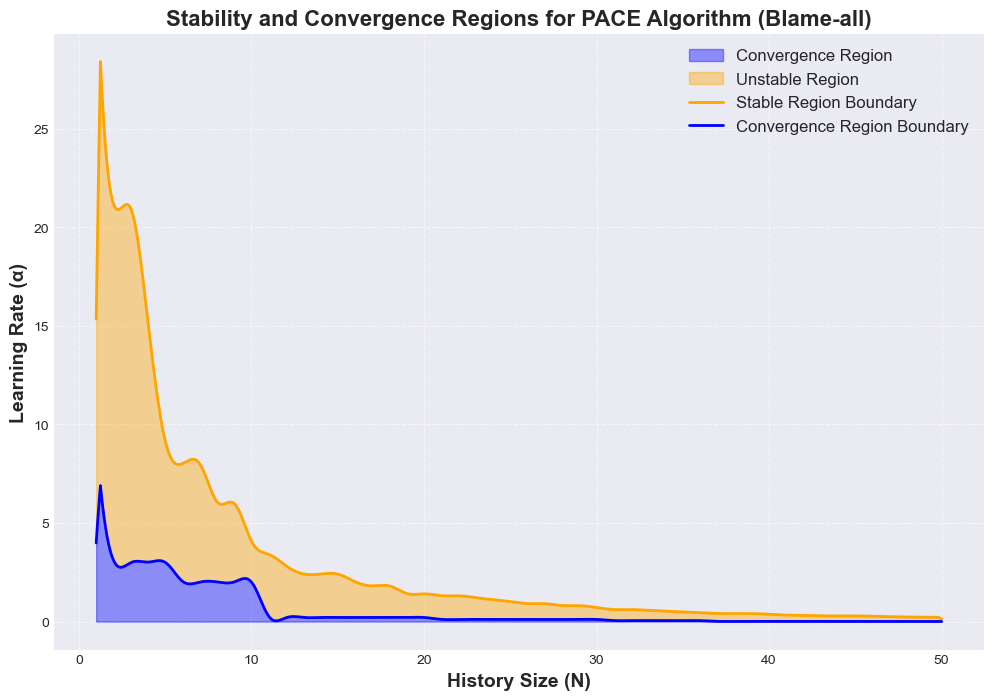

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Assuming stable_region_blame_all and convergence_region_blame_all are numpy arrays
# Shape: (num_points, 2) where each row is [N, α]

# Fit smooth curves to the stable and convergence regions
stable_N_blame_all = stable_region_blame_all[:, 0]
stable_alpha_blame_all = stable_region_blame_all[:, 1]
convergence_N_blame_all = convergence_region_blame_all[:, 0]
convergence_alpha_blame_all = convergence_region_blame_all[:, 1]

# Use spline interpolation for a smooth trend (degree k=4 for quartic spline)
stable_spline_blame_all = make_interp_spline(stable_N_blame_all, stable_alpha_blame_all, k=3)
convergence_spline_blame_all = make_interp_spline(convergence_N_blame_all, convergence_alpha_blame_all, k=3)

# Generate finer data points for smooth plotting
N_fine_blame_all = np.linspace(1, 50, 1000)  # Increased resolution for smoother plot
stable_alpha_fine_blame_all = stable_spline_blame_all(N_fine_blame_all)
convergence_alpha_fine_blame_all = convergence_spline_blame_all(N_fine_blame_all)

# Define a moving average function
def moving_average(data, window_size=10):
    """
    Apply a moving average smoothing filter to the data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Apply moving average smoothing to the interpolated data
stable_alpha_fine_smoothed_blame_all = moving_average(stable_alpha_fine_blame_all, window_size=10)
convergence_alpha_fine_smoothed_blame_all = moving_average(convergence_alpha_fine_blame_all, window_size=10)

# Save the smoothed boundaries data
stable_boundary_data_blame_all = np.vstack((N_fine_blame_all, stable_alpha_fine_smoothed_blame_all)).T
convergence_boundary_data_blame_all = np.vstack((N_fine_blame_all, convergence_alpha_fine_smoothed_blame_all)).T

# Save to CSV files
np.savetxt("stable_boundary_blame_all.csv", stable_boundary_data_blame_all, delimiter=",", header="N,alpha", comments="")
np.savetxt("convergence_boundary_blame_all.csv", convergence_boundary_data_blame_all, delimiter=",", header="N,alpha", comments="")

# Plot the regions and fitted curves
plt.figure(figsize=(12, 8))

# Fill the convergence region (blue)
plt.fill_between(N_fine_blame_all, 0, convergence_alpha_fine_smoothed_blame_all, color='blue', alpha=0.4, label='Convergence Region')

# Fill the stable (but not convergent) region (orange)
plt.fill_between(N_fine_blame_all, convergence_alpha_fine_smoothed_blame_all, stable_alpha_fine_smoothed_blame_all, color='orange', alpha=0.4, label='Unstable Region')

# Plot the fitted curves
plt.plot(N_fine_blame_all, stable_alpha_fine_smoothed_blame_all, color='orange', linewidth=2, label='Stable Region Boundary')
plt.plot(N_fine_blame_all, convergence_alpha_fine_smoothed_blame_all, color='blue', linewidth=2, label='Convergence Region Boundary')

# Add labels and title
plt.xlabel('History Size (N)', fontsize=14, fontweight='bold')
plt.ylabel('Learning Rate (α)', fontsize=14, fontweight='bold')
plt.title('Stability and Convergence Regions for PACE Algorithm (Blame-all)', fontsize=16, fontweight='bold')

# Add legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


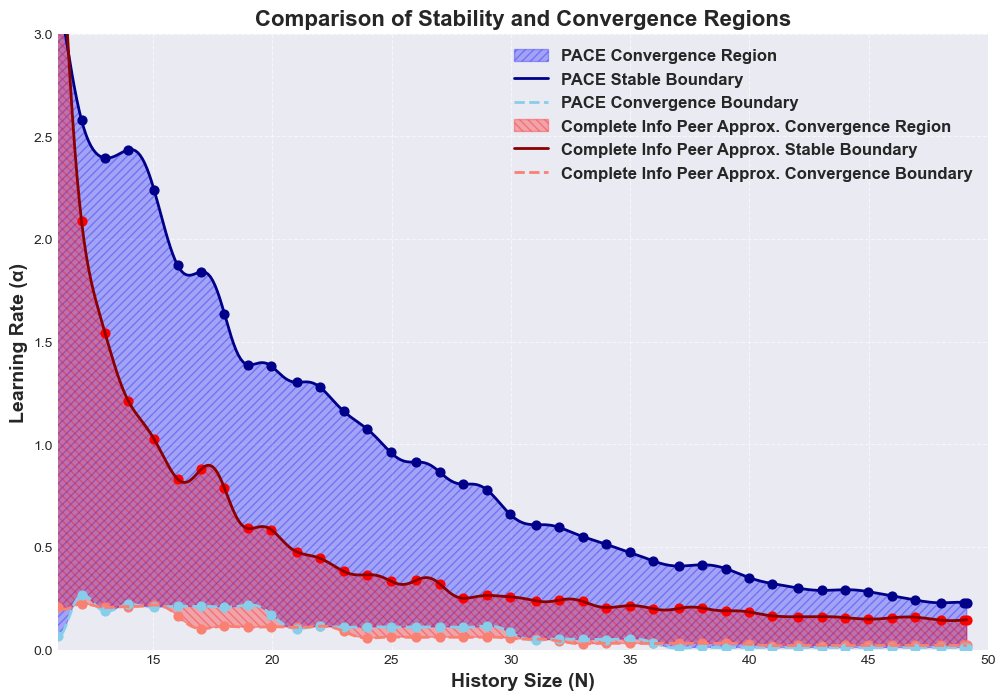

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Simple moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Function to fit and generate a smooth spline, and then apply moving average
def smooth_boundary_with_spline_and_moving_average(N, alpha, num_points=300, window_size=2):
    # Sort the data by N
    sorted_indices = np.argsort(N)
    N_sorted = np.array(N)[sorted_indices]
    alpha_sorted = np.array(alpha)[sorted_indices]

    # Fit a spline
    spline = make_interp_spline(N_sorted, alpha_sorted, k=5)
    N_spline = np.linspace(N_sorted.min(), N_sorted.max(), num_points)
    alpha_spline = spline(N_spline)

    # Apply moving average to the spline data
    alpha_smooth = moving_average(alpha_spline, window_size)

    # Adjust N to match the reduced size after moving average
    N_smooth = N_spline[:len(alpha_smooth)]
    return N_smooth, alpha_smooth

# Apply smoothing with spline and moving average to both datasets
num_points = 500  # Number of points to generate from the spline
window_size = 10   # Window size for moving average

# For blame_me
stable_N_blame_me_smooth, stable_alpha_blame_me_smooth = smooth_boundary_with_spline_and_moving_average(
    stable_N_blame_me, stable_alpha_blame_me, num_points, window_size)
convergence_N_blame_me_smooth, convergence_alpha_blame_me_smooth = smooth_boundary_with_spline_and_moving_average(
    convergence_N_blame_me, convergence_alpha_blame_me, num_points, window_size)

# For blame_all
stable_N_blame_all_smooth, stable_alpha_blame_all_smooth = smooth_boundary_with_spline_and_moving_average(
    stable_N_blame_all, stable_alpha_blame_all, num_points, window_size)
convergence_N_blame_all_smooth, convergence_alpha_blame_all_smooth = smooth_boundary_with_spline_and_moving_average(
    convergence_N_blame_all, convergence_alpha_blame_all, num_points, window_size)

# Specific N values to highlight (starting from N=11)
highlight_N_values = np.arange(11, 51)

# Function to find the corresponding α for specific N values on the boundaries
def find_boundary_points(N_smooth, alpha_smooth, highlight_N_values):
    points = []
    for N in highlight_N_values:
        # Find the closest N value in the smoothed boundary
        idx = np.abs(N_smooth - N).argmin()
        points.append((N_smooth[idx], alpha_smooth[idx]))
    return np.array(points)

# Find points for plotting on the boundaries
blame_me_stable_points = find_boundary_points(stable_N_blame_me_smooth, stable_alpha_blame_me_smooth, highlight_N_values)
blame_me_convergence_points = find_boundary_points(convergence_N_blame_me_smooth, convergence_alpha_blame_me_smooth, highlight_N_values)
blame_all_stable_points = find_boundary_points(stable_N_blame_all_smooth, stable_alpha_blame_all_smooth, highlight_N_values)
blame_all_convergence_points = find_boundary_points(convergence_N_blame_all_smooth, convergence_alpha_blame_all_smooth, highlight_N_values)

# Create a figure
plt.figure(figsize=(12, 8))

# Plot for PACE (Blame_all)
plt.fill_between(
    stable_N_blame_all_smooth,
    convergence_alpha_blame_all_smooth,
    stable_alpha_blame_all_smooth,
    color='blue',
    alpha=0.3,
    hatch='////',  # Higher frequency hatching for the PACE region
    label='PACE Convergence Region'
)
plt.plot(stable_N_blame_all_smooth, stable_alpha_blame_all_smooth, color='darkblue', linewidth=2, label='PACE Stable Boundary')
plt.plot(convergence_N_blame_all_smooth, convergence_alpha_blame_all_smooth, color='skyblue', linestyle='--', linewidth=2, label='PACE Convergence Boundary')

# Plot for Complete Information Peer Approximation (Blame_me)
plt.fill_between(
    stable_N_blame_me_smooth,
    convergence_alpha_blame_me_smooth,
    stable_alpha_blame_me_smooth,
    color='red',
    alpha=0.3,
    hatch='\\\\\\\\',  # Higher frequency hatching for the Complete Info region
    label='Complete Info Peer Approx. Convergence Region'
)
plt.plot(stable_N_blame_me_smooth, stable_alpha_blame_me_smooth, color='darkred', linewidth=2, label='Complete Info Peer Approx. Stable Boundary')
plt.plot(convergence_N_blame_me_smooth, convergence_alpha_blame_me_smooth, color='salmon', linestyle='--', linewidth=2, label='Complete Info Peer Approx. Convergence Boundary')

# Plot the highlighted points (no labels, larger dots)
plt.scatter(blame_me_stable_points[:, 0], blame_me_stable_points[:, 1], color='red', s=40)
plt.scatter(blame_me_convergence_points[:, 0], blame_me_convergence_points[:, 1], color='salmon', s=40)
plt.scatter(blame_all_stable_points[:, 0], blame_all_stable_points[:, 1], color='darkblue', s=40)
plt.scatter(blame_all_convergence_points[:, 0], blame_all_convergence_points[:, 1], color='skyblue', s=40)

# Axis adjustments
plt.xlabel('History Size (N)', fontsize=14, fontweight='bold')
plt.ylabel('Learning Rate (α)', fontsize=14, fontweight='bold')
plt.ylim(0, 3)  # Adjusting alpha to show only values <= 3
plt.xlim(11, 50)  # Adjusting N limits
plt.title('Comparison of Stability and Convergence Regions', fontsize=16, fontweight='bold')
plt.legend(prop={'size': 12, 'weight': 'bold'})  # Adjust legend properties
plt.grid(True, linestyle='--', alpha=0.6)

# Save the figure
plt.savefig('comparison_stability_convergence_regions.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


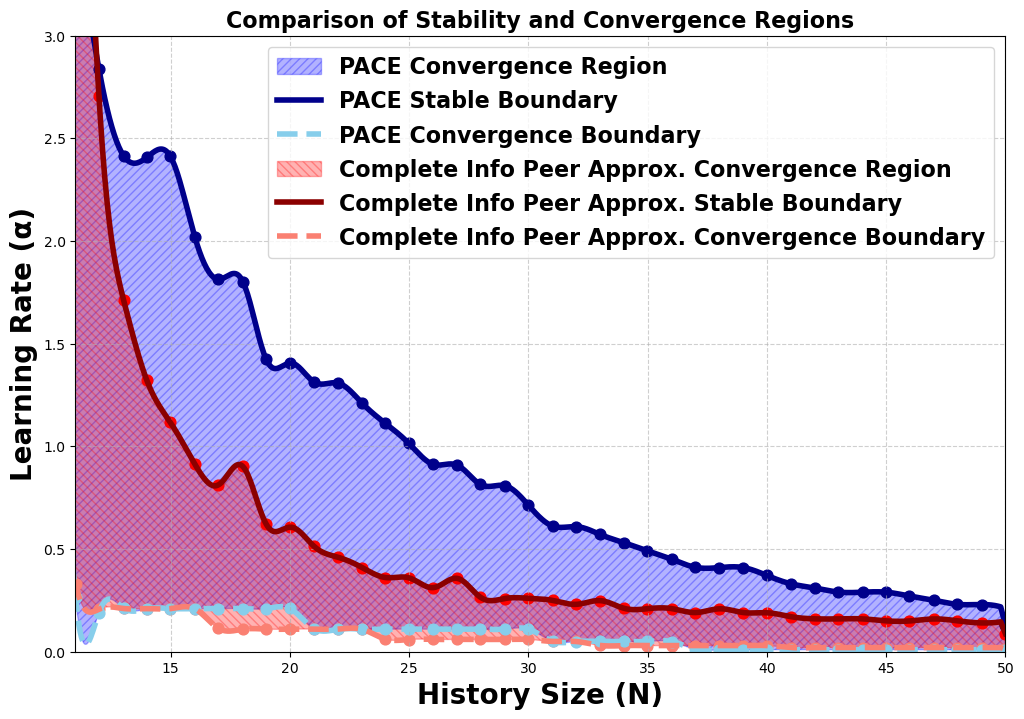

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Load data from CSV files
stable_boundary_blame_me = np.loadtxt("stable_boundary_blame_me.csv", delimiter=",", skiprows=1)
convergence_boundary_blame_me = np.loadtxt("convergence_boundary_blame_me.csv", delimiter=",", skiprows=1)
stable_boundary_blame_all = np.loadtxt("stable_boundary_blame_all.csv", delimiter=",", skiprows=1)
convergence_boundary_blame_all = np.loadtxt("convergence_boundary_blame_all.csv", delimiter=",", skiprows=1)

# Extract N and α values from loaded data
stable_N_blame_me, stable_alpha_blame_me = stable_boundary_blame_me[:, 0], stable_boundary_blame_me[:, 1]
convergence_N_blame_me, convergence_alpha_blame_me = convergence_boundary_blame_me[:, 0], convergence_boundary_blame_me[:, 1]
stable_N_blame_all, stable_alpha_blame_all = stable_boundary_blame_all[:, 0], stable_boundary_blame_all[:, 1]
convergence_N_blame_all, convergence_alpha_blame_all = convergence_boundary_blame_all[:, 0], convergence_boundary_blame_all[:, 1]

# Specific N values to highlight (starting from N=11)
highlight_N_values = np.arange(11, 51)

# Function to find the corresponding α for specific N values on the boundaries
def find_boundary_points(N_smooth, alpha_smooth, highlight_N_values):
    points = []
    for N in highlight_N_values:
        # Find the closest N value in the smoothed boundary
        idx = np.abs(N_smooth - N).argmin()
        points.append((N_smooth[idx], alpha_smooth[idx]))
    return np.array(points)

# Find points for plotting on the boundaries
blame_me_stable_points = find_boundary_points(stable_N_blame_me, stable_alpha_blame_me, highlight_N_values)
blame_me_convergence_points = find_boundary_points(convergence_N_blame_me, convergence_alpha_blame_me, highlight_N_values)
blame_all_stable_points = find_boundary_points(stable_N_blame_all, stable_alpha_blame_all, highlight_N_values)
blame_all_convergence_points = find_boundary_points(convergence_N_blame_all, convergence_alpha_blame_all, highlight_N_values)

# Create a figure
plt.figure(figsize=(12, 8))

# Plot for PACE (Blame_all)
plt.fill_between(
    stable_N_blame_all,
    convergence_alpha_blame_all,
    stable_alpha_blame_all,
    color='blue',
    alpha=0.3,
    hatch='////',  # Higher frequency hatching for the PACE region
    label='PACE Convergence Region'
)
plt.plot(stable_N_blame_all, stable_alpha_blame_all, color='darkblue', linewidth=4, label='PACE Stable Boundary')
plt.plot(convergence_N_blame_all, convergence_alpha_blame_all, color='skyblue', linestyle='--', linewidth=4, label='PACE Convergence Boundary')

# Plot for Complete Information Peer Approximation (Blame_me)
plt.fill_between(
    stable_N_blame_me,
    convergence_alpha_blame_me,
    stable_alpha_blame_me,
    color='red',
    alpha=0.3,
    hatch='\\\\\\\\',  # Higher frequency hatching for the Complete Info region
    label='Complete Info Peer Approx. Convergence Region'
)
plt.plot(stable_N_blame_me, stable_alpha_blame_me, color='darkred', linewidth=4, label='Complete Info Peer Approx. Stable Boundary')
plt.plot(convergence_N_blame_me, convergence_alpha_blame_me, color='salmon', linestyle='--', linewidth=4, label='Complete Info Peer Approx. Convergence Boundary')

# Plot the highlighted points (no labels, larger dots)
plt.scatter(blame_me_stable_points[:, 0], blame_me_stable_points[:, 1], color='red', s=60)
plt.scatter(blame_me_convergence_points[:, 0], blame_me_convergence_points[:, 1], color='salmon', s=60)
plt.scatter(blame_all_stable_points[:, 0], blame_all_stable_points[:, 1], color='darkblue', s=60)
plt.scatter(blame_all_convergence_points[:, 0], blame_all_convergence_points[:, 1], color='skyblue', s=60)

# Axis adjustments
plt.xlabel('History Size (N)', fontsize=20, fontweight='bold')
plt.ylabel('Learning Rate (α)', fontsize=20, fontweight='bold')
plt.ylim(0, 3)  # Adjusting alpha to show only values <= 3
plt.xlim(11, 50)  # Adjusting N limits
plt.title('Comparison of Stability and Convergence Regions', fontsize=16, fontweight='bold')
plt.legend(prop={'size': 16, 'weight': 'bold'})  # Adjust legend properties
plt.grid(True, linestyle='--', alpha=0.6)

# Save the figure
plt.savefig('comparison_stability_convergence_regions.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


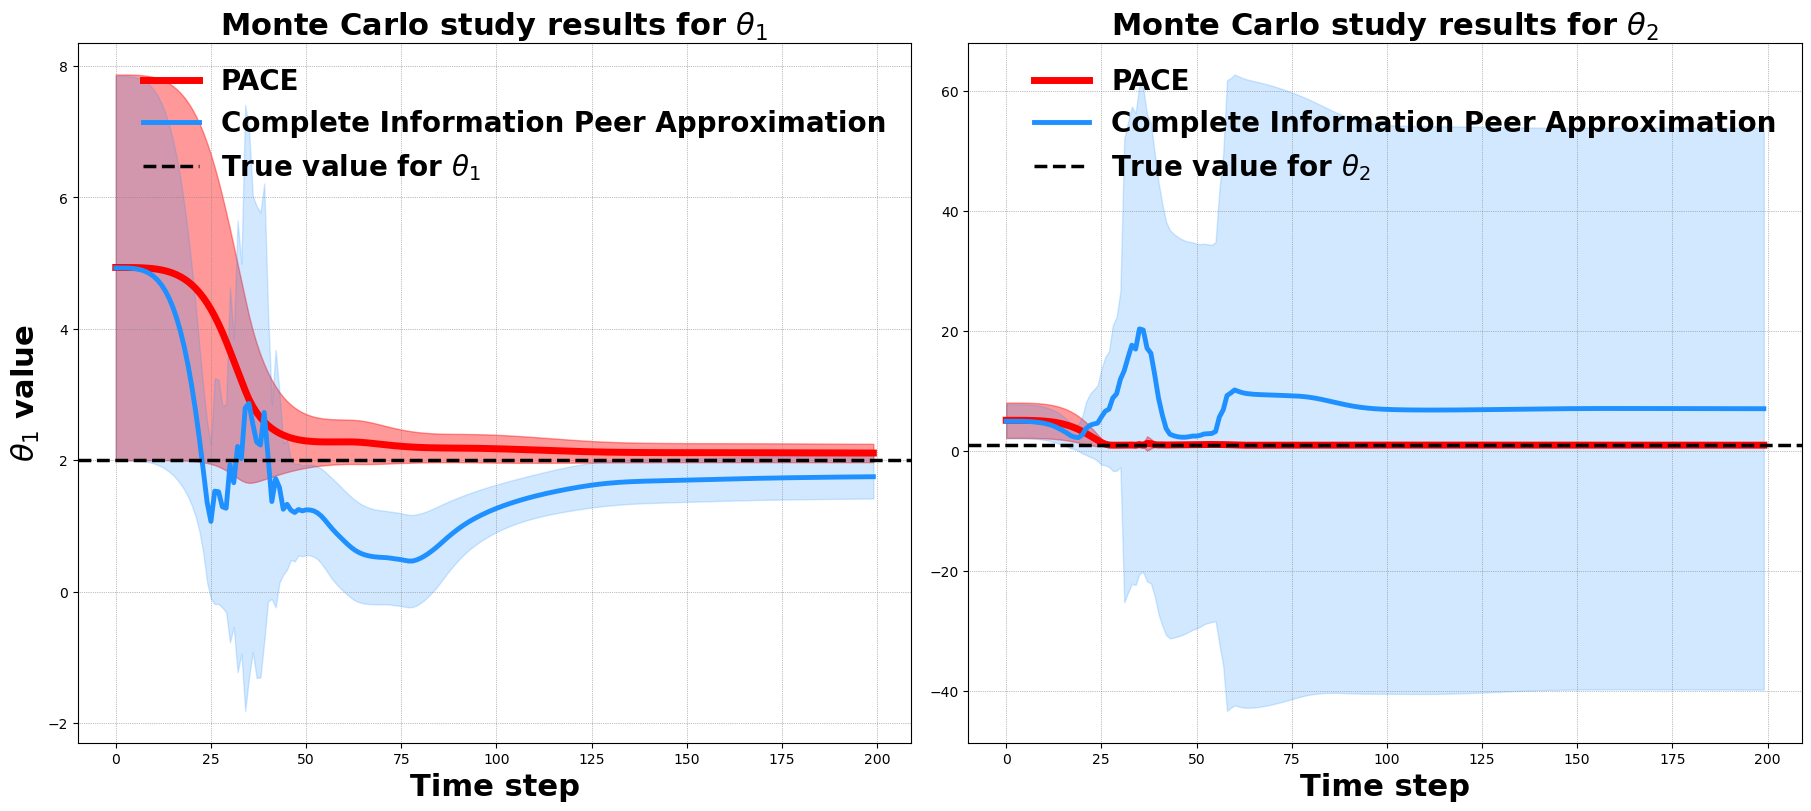

'Monte_Carlo_Study_Results.png'

In [31]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)

# Plot for Agent 1
axes[0].plot(agent1_mean, color='red', linewidth=5, label='PACE')  # Bright red for PACE
axes[0].fill_between(
    range(num_steps),
    agent1_mean - agent1_std,
    agent1_mean + agent1_std,
    color='red',
    alpha=0.4  # Darker fill for SD
)
axes[0].plot(agent1_mean_blame_me, color='dodgerblue', linewidth=3.5, label='Complete Information Peer Approximation')  # Slightly darker blue
axes[0].fill_between(
    range(num_steps),
    agent1_mean_blame_me - agent1_std_blame_me,
    agent1_mean_blame_me + agent1_std_blame_me,
    color='dodgerblue',
    alpha=0.2
)
axes[0].axhline(y=2.0, color='black', linestyle='--', linewidth=2.5, label=r'True value for $\theta_1$')
axes[0].set_xlabel('Time step', fontsize=22, fontweight='bold')
axes[0].set_ylabel(r'$\theta_1$ value', fontsize=22, fontweight='bold')

axes[0].legend(
    prop={'size': 20, 'weight': 'bold'}, loc='best', frameon=False  # Adjusted legend properties
)
axes[0].grid(color='gray', linestyle=':', linewidth=0.5)
axes[0].set_title('Monte Carlo study results for $\\theta_1$', fontsize=22, fontweight='bold')

# Plot for Agent 2
axes[1].plot(agent2_mean, color='red', linewidth=5, label='PACE')  # Bright red for PACE
axes[1].fill_between(
    range(num_steps),
    agent2_mean - agent2_std,
    agent2_mean + agent2_std,
    color='red',
    alpha=0.4  # Darker fill for SD
)
axes[1].plot(agent2_mean_blame_me, color='dodgerblue', linewidth=3.5, label='Complete Information Peer Approximation')  # Slightly darker blue
axes[1].fill_between(
    range(num_steps),
    agent2_mean_blame_me - agent2_std_blame_me,
    agent2_mean_blame_me + agent2_std_blame_me,
    color='dodgerblue',
    alpha=0.2
)
axes[1].axhline(y=1.0, color='black', linestyle='--', linewidth=2.5, label=r'True value for $\theta_2$')
axes[1].set_xlabel('Time step', fontsize=22, fontweight='bold')

axes[1].legend(
    prop={'size': 20, 'weight': 'bold'}, loc='best', frameon=False  # Adjusted legend properties
)
axes[1].grid(color='gray', linestyle=':', linewidth=0.5)
axes[1].set_title('Monte Carlo study results for $\\theta_2$', fontsize=22, fontweight='bold')

# Save the figure
file_path = "Monte_Carlo_Study_Results.png"
plt.savefig(file_path, dpi=300)

plt.show()

file_path


C:\Users\ssoltan2\AppData\Local\Temp\ipykernel_55172\3907149229.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


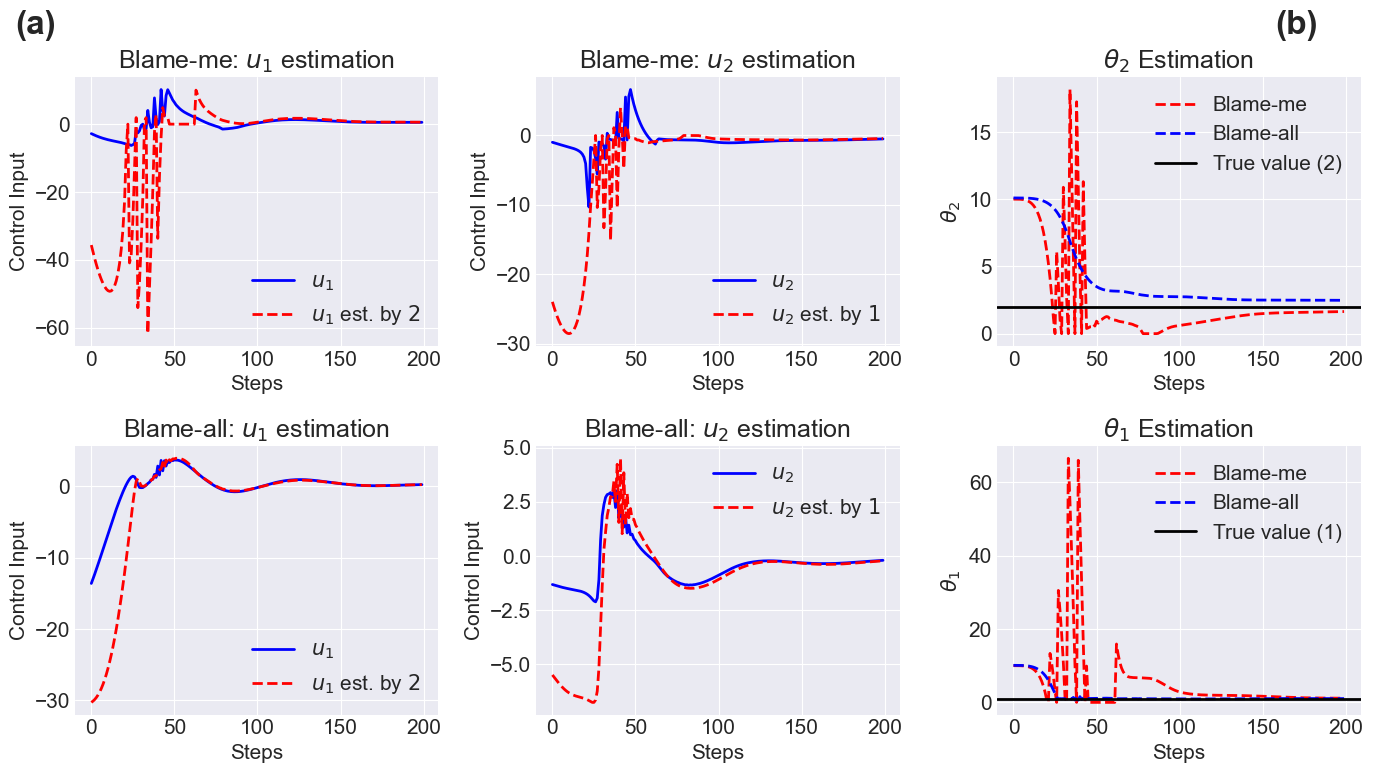

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Increase font size for all plot elements globally
plt.rcParams.update({'font.size': 15})  # Double the default font size

# Create the figure with subplots: 2x2 on the left (a) and 2x1 on the right (b)
fig = plt.figure(figsize=(14, 8))

# Apply professional styling for the background and grid
plt.style.use('seaborn-darkgrid')

# 2x2 grid for u parameters (left side) - labeled (a)
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(u1_blame_me[:800], 'b-', linewidth=2, label=r'$u_1$')
ax1.plot(u2_est_blame_me[:800], 'r--', linewidth=2, label=r'$u_1$ est. by $2$')
ax1.set_title('Blame-me: $u_1$ estimation')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Control Input')
ax1.legend()

ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(u2_blame_me[:800], 'b-', linewidth=2, label=r'$u_2$')
ax2.plot(u1_est_blame_me[:800], 'r--', linewidth=2, label=r'$u_2$ est. by $1$')
ax2.set_title('Blame-me: $u_2$ estimation')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Control Input')
ax2.legend()

ax3 = fig.add_subplot(2, 3, 4)
ax3.plot(u1_blame_all[:800], 'b-', linewidth=2, label=r'$u_1$')
ax3.plot(u2_est_blame_all[:800], 'r--', linewidth=2, label=r'$u_1$ est. by $2$')
ax3.set_title('Blame-all: $u_1$ estimation')
ax3.set_xlabel('Steps')
ax3.set_ylabel('Control Input')
ax3.legend()

ax4 = fig.add_subplot(2, 3, 5)
ax4.plot(u2_blame_all[:800], 'b-', linewidth=2, label=r'$u_2$')
ax4.plot(u1_est_blame_all[:800], 'r--', linewidth=2, label=r'$u_2$ est. by $1$')
ax4.set_title('Blame-all: $u_2$ estimation')
ax4.set_xlabel('Steps')
ax4.set_ylabel('Control Input')
ax4.legend()

# Add (a) label
fig.text(0.02, 0.95, '(a)', fontsize=24, fontweight='bold', va='center')

# 2x1 grid for Q parameter estimations (right side) - labeled (b)
ax5 = fig.add_subplot(2, 3, 3)
ax5.plot(Q1_diag_0_history_me[:800], 'r--', linewidth=2, label='Blame-me')
ax5.plot(Q1_diag_0_history_all[:800], 'b--', linewidth=2, label='Blame-all')
ax5.axhline(y=2, color='k', linestyle='-', linewidth=2, label='True value (2)')
ax5.set_title(r'$\theta_{2}$ Estimation')
ax5.set_xlabel('Steps')
ax5.set_ylabel(r'$\theta_2$')
ax5.legend()

ax6 = fig.add_subplot(2, 3, 6)
ax6.plot(Q2_diag_0_history_me[:800], 'r--', linewidth=2, label='Blame-me')
ax6.plot(Q2_diag_0_history_all[:800], 'b--', linewidth=2, label='Blame-all')
ax6.axhline(y=1, color='k', linestyle='-', linewidth=2, label='True value (1)')
ax6.set_title(r'$\theta_{1}$ Estimation')
ax6.set_xlabel('Steps')
ax6.set_ylabel(r'$\theta_1$')
ax6.legend()

# Add (b) label
fig.text(0.92, 0.95, '(b)', fontsize=24, fontweight='bold', va='center')

# Adjust layout for the whole figure
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure as a single file
plt.savefig("combined_figure.png", dpi=300)

# Show the plot
plt.show()


C:\Users\ssoltan2\AppData\Local\Temp\ipykernel_55172\978418691.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


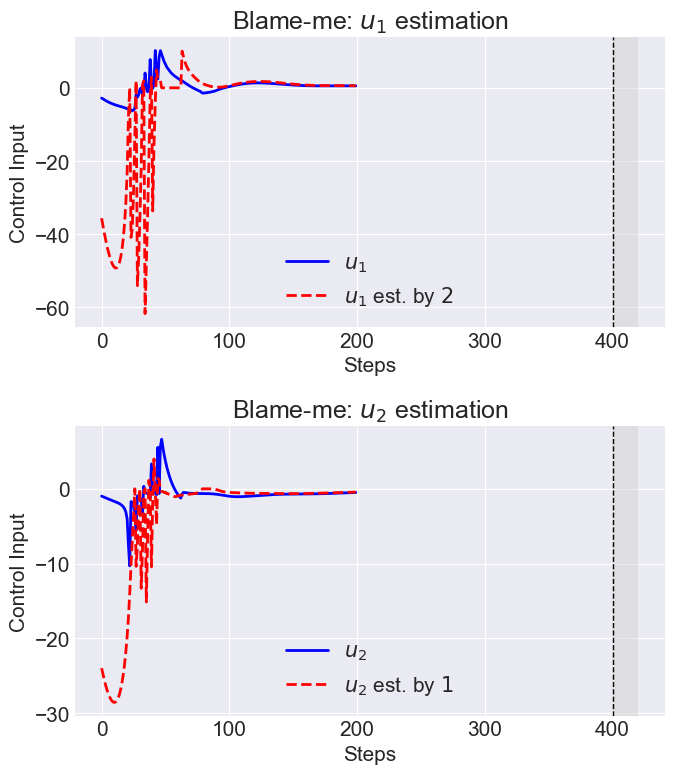

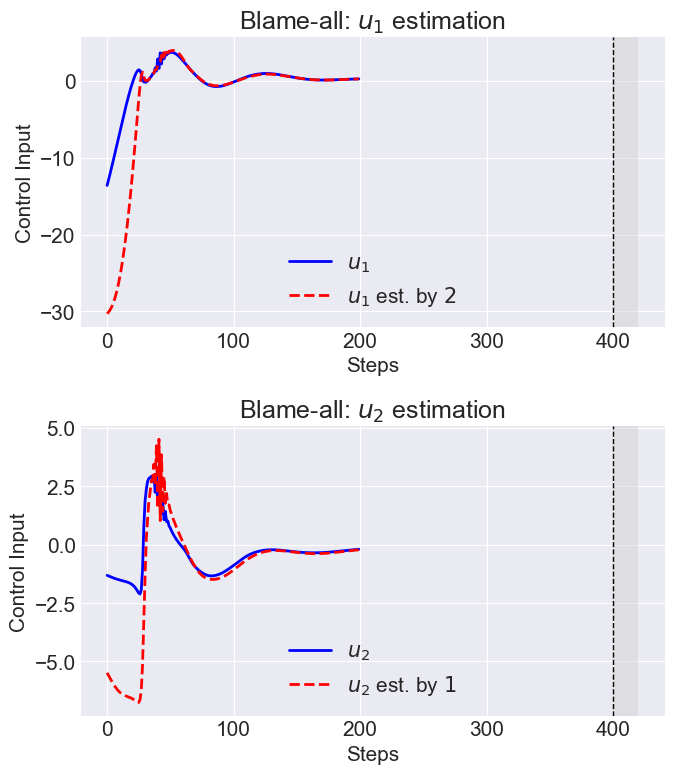

C:\ProgramData\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


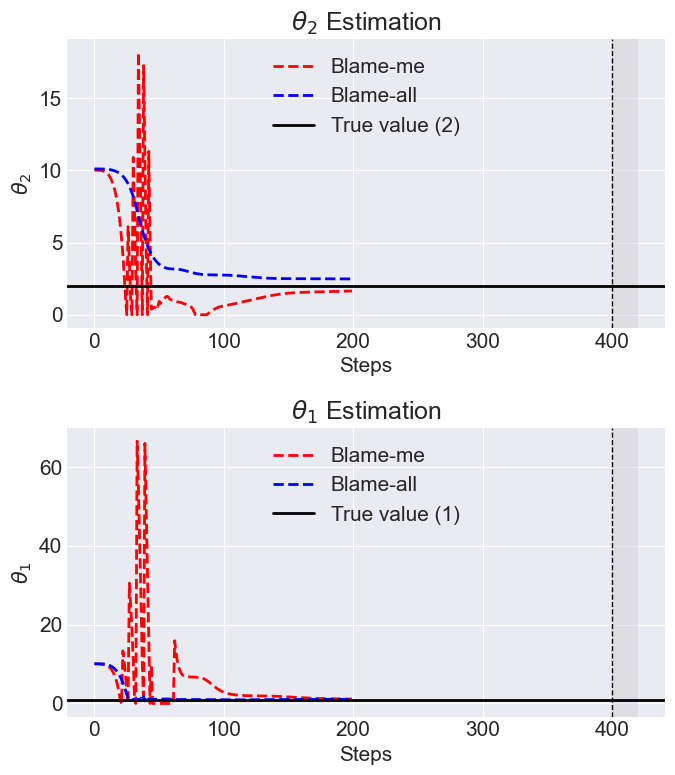

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Increase font size for all plot elements globally
plt.rcParams.update({'font.size': 15})  # Adjust font size as needed

# Apply professional styling for the background and grid
plt.style.use('seaborn-darkgrid')

# Function to shade background after x=400 with a more noticeable color difference
def shade_background(ax, x_limit):
    ax.axvline(x=x_limit, color='k', linestyle='--', linewidth=1)
    ax.axvspan(x_limit, ax.get_xlim()[1], facecolor='lightgrey', alpha=0.5)

### Figure 1 ###
fig1, axs1 = plt.subplots(2, 1, figsize=(7, 8))

# First subplot
axs1[0].plot(u1_blame_me[:800], 'b-', linewidth=2, label=r'$u_1$')
axs1[0].plot(u2_est_blame_me[:800], 'r--', linewidth=2, label=r'$u_1$ est. by $2$')
axs1[0].set_title('Blame-me: $u_1$ estimation')
axs1[0].set_xlabel('Steps')
axs1[0].set_ylabel('Control Input')
axs1[0].legend()
shade_background(axs1[0], 400)

# Second subplot
axs1[1].plot(u2_blame_me[:800], 'b-', linewidth=2, label=r'$u_2$')
axs1[1].plot(u1_est_blame_me[:800], 'r--', linewidth=2, label=r'$u_2$ est. by $1$')
axs1[1].set_title('Blame-me: $u_2$ estimation')
axs1[1].set_xlabel('Steps')
axs1[1].set_ylabel('Control Input')
axs1[1].legend()
shade_background(axs1[1], 400)

# Adjust layout and save
fig1.tight_layout()
fig1.savefig("figure1.png", dpi=300)
plt.show()

### Figure 2 ###
fig2, axs2 = plt.subplots(2, 1, figsize=(7, 8))

# First subplot
axs2[0].plot(u1_blame_all[:800], 'b-', linewidth=2, label=r'$u_1$')
axs2[0].plot(u2_est_blame_all[:800], 'r--', linewidth=2, label=r'$u_1$ est. by $2$')
axs2[0].set_title('Blame-all: $u_1$ estimation')
axs2[0].set_xlabel('Steps')
axs2[0].set_ylabel('Control Input')
axs2[0].legend()
shade_background(axs2[0], 400)

# Second subplot
axs2[1].plot(u2_blame_all[:800], 'b-', linewidth=2, label=r'$u_2$')
axs2[1].plot(u1_est_blame_all[:800], 'r--', linewidth=2, label=r'$u_2$ est. by $1$')
axs2[1].set_title('Blame-all: $u_2$ estimation')
axs2[1].set_xlabel('Steps')
axs2[1].set_ylabel('Control Input')
axs2[1].legend()
shade_background(axs2[1], 400)

# Adjust layout and save
fig2.tight_layout()
fig2.savefig("figure2.png", dpi=300)
plt.show()

### Figure 3 ###
fig3, axs3 = plt.subplots(2, 1, figsize=(7, 8))

# First subplot
axs3[0].plot(Q1_diag_0_history_me[:800], 'r--', linewidth=2, label='Blame-me')
axs3[0].plot(Q1_diag_0_history_all[:800], 'b--', linewidth=2, label='Blame-all')
axs3[0].axhline(y=2, color='k', linestyle='-', linewidth=2, label='True value (2)')
axs3[0].set_title(r'$\theta_{2}$ Estimation')
axs3[0].set_xlabel('Steps')
axs3[0].set_ylabel(r'$\theta_2$')
axs3[0].legend()
shade_background(axs3[0], 400)

# Second subplot
axs3[1].plot(Q2_diag_0_history_me[:800], 'r--', linewidth=2, label='Blame-me')
axs3[1].plot(Q2_diag_0_history_all[:800], 'b--', linewidth=2, label='Blame-all')
axs3[1].axhline(y=1, color='k', linestyle='-', linewidth=2, label='True value (1)')
axs3[1].set_title(r'$\theta_{1}$ Estimation')
axs3[1].set_xlabel('Steps')
axs3[1].set_ylabel(r'$\theta_1$')
axs3[1].legend()
shade_background(axs3[1], 400)

# Adjust layout and save
fig3.tight_layout()
fig3.savefig("figure3.png", dpi=300)
plt.show()


C:\Users\ssoltan2\AppData\Local\Temp\ipykernel_55172\103344728.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


ValueError: x and y must have same first dimension, but have shapes (800,) and (200, 1)

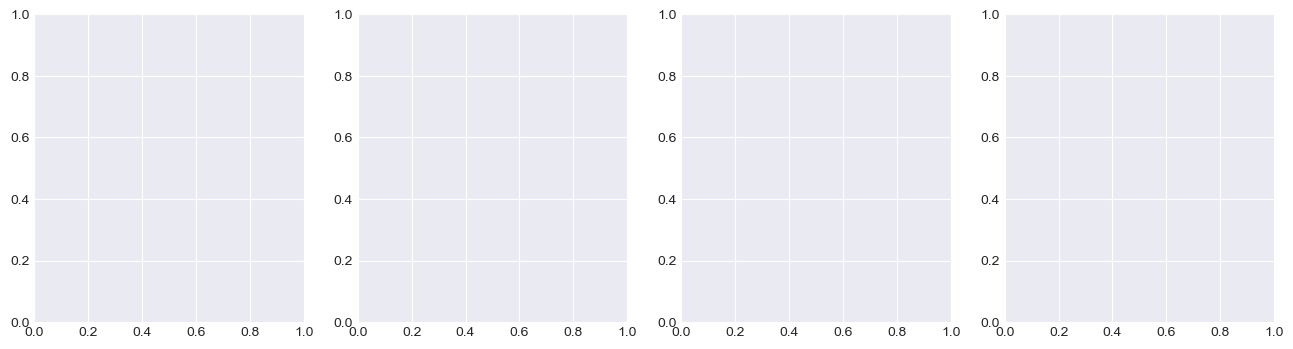

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming each data series is sampled at 0.01 seconds
sampling_time = 0.01
num_samples = 800  # Plotting up to 800 samples as per the original code
time_vector = np.arange(0, num_samples * sampling_time, sampling_time)

# Increase font size for all plot elements globally
plt.rcParams.update({'font.size': 10})  # Adjust font size as needed

# Apply professional styling for the background and grid
plt.style.use('seaborn-darkgrid')

# Function to shade background after time=4 seconds (corresponding to x=400 in steps) with a noticeable color difference
def shade_background(ax, time_limit):
    ax.axvline(x=time_limit, color='k', linestyle='--', linewidth=1)
    ax.axvspan(time_limit, ax.get_xlim()[1], facecolor='lightgrey', alpha=0.5)

# Create a wider figure with a single row of 4 columns
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # Adjust width to 16 for better readability

# First plot: Blame-me u1 estimation
axs[0].plot(time_vector, u1_blame_me[:800], color='blue', linestyle='-', linewidth=2, label=r'$u_1$')
axs[0].plot(time_vector, u2_est_blame_me[:800], color='orange', linestyle='--', linewidth=2, label=r'$u_1$ est. by $2$')
axs[0].set_title('Blame-me: $u_1$ estimation')
axs[0].set_xlabel('Time (sec)')
axs[0].set_ylabel('Control Input')
axs[0].legend()
shade_background(axs[0], 4)  # Shading after time = 4 seconds

# Second plot: Blame-me u2 estimation
axs[1].plot(time_vector, u2_blame_me[:800], color='blue', linestyle='-', linewidth=2, label=r'$u_2$')
axs[1].plot(time_vector, u1_est_blame_me[:800], color='orange', linestyle='--', linewidth=2, label=r'$u_2$ est. by $1$')
axs[1].set_title('Blame-me: $u_2$ estimation')
axs[1].set_xlabel('Time (sec)')
axs[1].set_ylabel('Control Input')
axs[1].legend()
shade_background(axs[1], 4)

# Third plot: Theta2 estimation
axs[2].plot(time_vector, Q1_diag_0_history_me[:800], color='red', linestyle='--', linewidth=2, label='Blame-me')
axs[2].plot(time_vector, Q1_diag_0_history_all[:800], color='green', linestyle='-.', linewidth=2, label='Blame-all')
axs[2].axhline(y=2, color='k', linestyle='-', linewidth=2, label='True value')
axs[2].set_title(r'$\theta_{2}$ Estimation')
axs[2].set_xlabel('Time (sec)')
axs[2].set_ylabel(r'$\theta_2$')
axs[2].legend()
shade_background(axs[2], 4)

# Fourth plot: Theta1 estimation
axs[3].plot(time_vector, Q2_diag_0_history_me[:800], color='red', linestyle='--', linewidth=2, label='Blame-me')
axs[3].plot(time_vector, Q2_diag_0_history_all[:800], color='green', linestyle='-.', linewidth=2, label='Blame-all')
axs[3].axhline(y=1, color='k', linestyle='-', linewidth=2, label='True value')
axs[3].set_title(r'$\theta_{1}$ Estimation')
axs[3].set_xlabel('Time (sec)')
axs[3].set_ylabel(r'$\theta_1$')
axs[3].legend()
shade_background(axs[3], 4)

# Add labels '(a)' and '(b)' in the top-left corner of the respective plot pairs
axs[0].text(-0.1, 1.1, '(a)', transform=axs[0].transAxes, fontsize=12, fontweight='bold', ha='center', va='center')
axs[2].text(-0.1, 1.1, '(b)', transform=axs[2].transAxes, fontsize=12, fontweight='bold', ha='center', va='center')

# Adjust layout to prevent overlap and fit single-row format
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Save the figure
plt.savefig('combined_figure_time_axis.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Assuming Q1_diag_0_history_me, Q1_diag_0_history_all, Q2_diag_0_history_me, Q2_diag_0_history_all are defined arrays

# True values for theta1 and theta2
theta1_true = 2.0
theta2_true = 1.0

# Function to find the first time all subsequent errors are below 10% of the true value
def find_time_below_10_percent(estimation, true_value, time_step=0.01):
    threshold = 0.1 * true_value
    for sample in range(len(estimation)):
        # Check if all subsequent errors are within 10% of the true value
        if all(abs(estimation[i] - true_value) / true_value < 0.1 for i in range(sample, len(estimation))):
            return sample * time_step
    return None

# Function to calculate error percentage at a specific sample
def calculate_error_percentage(estimation, true_value, sample):
    if sample < len(estimation):  # Check if the sample is within the array bounds
        error = abs(estimation[sample] - true_value) / true_value
        return error * 100
    else:
        return np.nan  # Return NaN if sample index is out of range

# Calculating required values
data = {
    "Metric": [
        "Time θ1 < 10% Error", 
        "Time θ2 < 10% Error", 
        "Error % at Sample 400 (θ1)", 
        "Error % at Sample 400 (θ2)", 
        "Error % at Last Sample (θ1)", 
        "Error % at Last Sample (θ2)"
    ],
    "Blame-me": [
        find_time_below_10_percent(Q1_diag_0_history_me, theta1_true),
        find_time_below_10_percent(Q2_diag_0_history_me, theta2_true),
        calculate_error_percentage(Q1_diag_0_history_me, theta1_true, 400),
        calculate_error_percentage(Q2_diag_0_history_me, theta2_true, 400),
        calculate_error_percentage(Q1_diag_0_history_me, theta1_true, len(Q1_diag_0_history_me) - 1),
        calculate_error_percentage(Q2_diag_0_history_me, theta2_true, len(Q2_diag_0_history_me) - 1)
    ],
    "Blame-all": [
        find_time_below_10_percent(Q1_diag_0_history_all, theta1_true),
        find_time_below_10_percent(Q2_diag_0_history_all, theta2_true),
        calculate_error_percentage(Q1_diag_0_history_all, theta1_true, 400),
        calculate_error_percentage(Q2_diag_0_history_all, theta2_true, 400),
        calculate_error_percentage(Q1_diag_0_history_all, theta1_true, len(Q1_diag_0_history_all) - 1),
        calculate_error_percentage(Q2_diag_0_history_all, theta2_true, len(Q2_diag_0_history_all) - 1)
    ]
}

# Creating the table
df = pd.DataFrame(data)

# Display the table
print(df)


In [ ]:
import pandas as pd

# Data provided
data = {
    "Metric": [
        "Time θ1 < 10% Error", 
        "Time θ2 < 10% Error", 
        "Error % at Sample 400 (θ1)", 
        "Error % at Sample 400 (θ2)", 
        "Error % at Last Sample (θ1)", 
        "Error % at Last Sample (θ2)"
    ],
    "Blame-me": [4.15, 4.76, 13.33, 16.30, 2.71, 7.01],
    "Blame-all": [4.08, 4.15, 11.50, 14.59, 1.63, 2.99]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Remove 'Metric' column and set index as the 'Metric' values (to transpose easily)
df = df.drop(columns=["Metric"]).T
df.columns = ["", "", "", "", "", ""]  # Empty column headers

# Format values to 2 decimal places and convert to LaTeX
latex_table = df.to_latex(index=True, header=False, float_format="%.2f")

# Output the LaTeX code
print(latex_table)
